In [27]:
import torch 
import torch_geometric
import numpy as np
from torch_geometric.datasets import TUDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
import os

#visualising data 
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

#data normalisation 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.nn.functional import normalize

from copy import deepcopy

#linear assignment problem
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from lapsolver import solve_dense
from scipy.sparse import coo_matrix, save_npz,load_npz

import multiprocessing as mp

import random 

import copy
from torch_geometric.data import Data

from torch_geometric.nn import EdgeConv
from torch_geometric.nn import ChebConv


In [28]:
import os
os.remove('PROTEINS/processed/data.pt')
os.remove('PROTEINS/processed/pre_filter.pt')
os.remove('PROTEINS/processed/pre_transform.pt')

In [29]:
data = TUDataset(root = '.', name='PROTEINS', use_node_attr =True, use_edge_attr =True)

Processing...
Done!


In [30]:
def split_data (dataset, train_perc, valid_perc):
    
    dataset.shuffle

    
    train_dataset = dataset[:int(train_perc*len(dataset))]

    
    valid_dataset = dataset[int(train_perc*len(dataset)):int((train_perc + valid_perc)*len(dataset))]

    
    test_dataset = dataset[int((train_perc + valid_perc)*len(dataset)):]


    return train_dataset, valid_dataset, test_dataset
    

In [31]:
loader = DataLoader(data, batch_size=32)

In [32]:
all_options = np.array([])

In [33]:
for batch in loader:
    npx = batch.x.numpy()
    all_options = np.unique(np.concatenate([all_options,np.unique(npx[:,0])]))

In [34]:
onehot = OneHotEncoder(categories=list(all_options.reshape(1,-1)), sparse_output=False)

In [35]:
os.remove('PROTEINS/processed/data.pt')
os.remove('PROTEINS/processed/pre_filter.pt')
os.remove('PROTEINS/processed/pre_transform.pt')

In [36]:
def norm_transform(data_obj): 
    new_data = deepcopy(data_obj)
    new_data.x = torch.cat(
        [
            torch.tensor(onehot.fit_transform(data_obj.x[:,0:1].numpy())),
            data_obj.x[:, 1:]
        ],
        -1
    )
    new_data.y = torch.unsqueeze(new_data.y, -1).float()
    return new_data

In [37]:
dataset = TUDataset(
    root = '.',
    name = 'PROTEINS',
    use_node_attr = True,
    use_edge_attr = True,
    pre_transform = norm_transform
)

Processing...
Done!


In [39]:
len(dataset)

1113

In [40]:
dataset[0].x

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], dtype=torch.float64)

In [41]:
train_dataset, valid_dataset, test_dataset = split_data (dataset, 0.8, 0.1)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=30, shuffle=True)

single_train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
single_valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [43]:
#part 1 fix random seed 

random.seed(31)
np.random.seed(31)
torch.manual_seed(31)

In [44]:
# here, we are going to define our model

class GNN(torch.nn.Module):
        

    def __init__(self, num_node_features, num_classes):
        
        super(GNN, self).__init__()
        
        # two GCN layers
        
        self.conv1 = GCNConv(num_node_features, 32)
        
        #self.pool1 = global_mean_pool(16, batch)
        
        #self.pool1 = TopKPooling(hidden_channels, ratio=0.5)
        
        
        self.conv2 = GCNConv(32, 32)
        
        self.conv3 = GCNConv(32, num_classes)
        
        

    

    def forward(self, data):
        
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        #x = F.dropout(x, training=self.training)
        
        # x = F.relu(x)
        #x = F.elu(x)
        
        
        intermediate_matrix_1 = x.clone()
        
        x = self.conv2(x, edge_index)
        #x = F.dropout(x, training=self.training)
        #x = F.elu(x)
        
        intermediate_matrix_2 = x.clone()

        
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, data.batch)
        

        #return F.log_softmax(x, dim=1), intermediate_matrix_1, intermediate_matrix_2
        return x, intermediate_matrix_1, intermediate_matrix_2

In [45]:
class GC(torch.nn.Module):
        

    def __init__(self, num_node_features, num_classes, K):
        
        super(GC, self).__init__()
        
        # two GCN layers
        
        self.conv1 = ChebConv(num_node_features, 32, K=K)
        
        #self.pool1 = global_mean_pool(16, batch)
        
        #self.pool1 = TopKPooling(hidden_channels, ratio=0.5)
        
        
        #self.conv2 = GCNConv(20, 32)
        
        self.conv2 = ChebConv(32, num_classes, K)

    

    def forward(self, data):
        
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.dropout(x, training=self.training)
        
        # x = F.relu(x)
        #x = F.elu(x)
        
        
        intermediate_matrix_1 = x.clone()
        
        x = self.conv2(x, edge_index)
        x = F.dropout(x, training=self.training)
        #x = F.elu(x)
        
        intermediate_matrix_2 = x.clone()

        
        #x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, data.batch)
        
      
        #return F.log_softmax(x, dim=1), intermediate_matrix_1, intermediate_matrix_2
        return x, intermediate_matrix_1, intermediate_matrix_2

In [46]:
class CoryGNN(torch.nn.Module):
        

    def __init__(self, num_node_features, num_classes):
        
        super(CoryGNN, self).__init__()
        
        # two GCN layers
        
        self.mlp1 = torch.nn.Sequential(
            torch.nn.Linear(2*num_node_features, 32),
            torch.nn.SiLU(),
            torch.nn.Linear(32,32),
            torch.nn.SiLU(),
            torch.nn.Linear(32,32)
        )
        
        self.conv1 = EdgeConv(
            self.mlp1,
            aggr='mean'
        )
        
        self.mlp2 = torch.nn.Sequential(
            torch.nn.Linear(2*32, 32),
            torch.nn.SiLU(),
            torch.nn.Linear(32,32),
            torch.nn.SiLU(),
            torch.nn.Linear(32,32)
        )
        
        self.conv2 = EdgeConv(
            self.mlp2,
            aggr='mean'
        )
        
        self.mlp3 = torch.nn.Sequential(
            torch.nn.Linear(2*32, num_classes)
        )
        
        self.conv3 = EdgeConv(
            self.mlp3,
            aggr='mean'
        )
        
        

    

    def forward(self, data):
        
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        
        # x = F.relu(x)
        #x = F.elu(x)
        
        
        intermediate_matrix_1 = x.clone()
        
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        
        intermediate_matrix_2 = x.clone()
        
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, data.batch)
        
       
        return x, intermediate_matrix_1, intermediate_matrix_2

In [47]:
def train_1_epoch(train_loader):
    
    
    for data in train_loader:

        model.train()
        optimizer.zero_grad()

        # get the current model's predictions
        preds,intermediate_matrix_1, intermediate_matrix_2 = model(data)

        # compute the loss

        #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        #print(preds.dtype, data.y.dtype)
        
    
        loss = criterion(preds, data.y)

        #loss = F.nll_loss(preds, data.y)

        
        # first, calculate which direction is "downhill" in terms of loss
        loss.backward()
        # second, take a step "downhill"
        optimizer.step()
    


In [48]:
def test(loader): 
    
    correct = 0
    total = 0
    
    total_loss = 0
    
    for data in loader: 
        model.eval()
        preds, intermediate_matrix_1, intermediate_matrix_2 = model(data)
        
        #_, predicted = preds.max(dim=1)
        #print(predicted)
        predicted = torch.round(torch.sigmoid(preds))
        
        correct += (predicted == data.y).sum().item()
        total += data.y.size(0)

        total_loss += criterion(preds, data.y)*data.y.size(0)
        
    accuracy = (correct / total)  * 100
    
    avg_loss = float((total_loss / total).detach().numpy())
    
    

    return accuracy, avg_loss

In [49]:
#model = GNN(dataset.num_node_features, dataset.num_classes)
model = CoryGNN(dataset.num_node_features, 1)

#model = GC(dataset.num_node_features, 1, 2)

# this already has a sigmoid function builtin 
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam( model.parameters(), 0.0003  )

In [50]:
print(dataset.num_node_features)

64


In [51]:
print(dataset.num_classes)

2


In [52]:

def plot_avg_loss(loader, epoch, max_epoch, avg_loss_array, epoch_array): 
    
    accuracy, avg_loss = test(loader)

    avg_loss_array.append(avg_loss)

    
    epoch_array.append(epoch)
    
    
    if epoch == max_epoch:
    
        
        plt.figure()
        #plt.scatter(epoch_array, avg_loss_array)
        plt.plot(epoch_array, avg_loss_array)


        plt.xlabel('epoch')
        plt.ylabel('avg_loss')
        plt.title('epoch vs avg_loss')

        plt.show()

In [53]:
def plot_accuracy(loader, epoch, max_epoch, accuracy_array, epoch_array ):
    
    
    accuracy, avg_loss = test(loader)
    
    accuracy_array.append(accuracy)
    epoch_array.append(epoch)
    
    if epoch == max_epoch:
        
        plt.figure()
        #plt.scatter(epoch_array, accuracy_array)
        plt.plot(epoch_array, accuracy_array)


        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('epoch vs accuracy')

        plt.show()

In [54]:
def make_folder(folder_name): 
    
    path = './' + folder_name
    
    os.makedirs(path, exist_ok=True)

In [55]:
def save_intermediate_matrix(folder_name, file_name_1, file_name_2, 
                             intermediate_matrix_1, intermediate_matrix_2 ): 
    
    # we have made a folder 
    make_folder(folder_name)
    
    
    intermediate_array_1 = intermediate_matrix_1.detach().numpy()
    
    intermediate_array_2 = intermediate_matrix_2.detach().numpy()
    
    
    # now, we need to save each matrix into the folder 
    
    file_path_1 = folder_name + '/' + file_name_1 
    file_path_2 = folder_name + '/' + file_name_2 
    
    np.savetxt(file_path_1, intermediate_array_1, fmt='%.4f', newline='\n')
    
    np.savetxt(file_path_2, intermediate_array_2, fmt='%.4f', newline='\n')
    

In [56]:
def save_all_intermediates(data_loader, epoch): 

    
    #firstly, i'm going to try and save graphs without doing any training 
    for single_no,single in enumerate(data_loader): 
            
        _, intermediate_matrix_1, intermediate_matrix_2 = model(single)

        save_intermediate_matrix('Protein_Model',
                                 f'e{epoch + 1}_g{single_no +1}_l1',
                                 f'e{epoch + 1}_g{single_no +1}_l2',
                         intermediate_matrix_1,
                                 intermediate_matrix_2 )

In [105]:
len(dataset)

1113

In [85]:
def load_graph(folder_name, epoch, no_graph_a, no_graph_b, layer_number): 
    
    
    # this method is going to have to change... the name of the file will be different
    
    folder_path = './' + folder_name
    
    # CORY NOTE -  changed the filenames to be a little less wordy
    file_name_a = f'e{epoch + 1}_g{no_graph_a +1}_l{layer_number}'
    file_name_b = f'e{epoch + 1}_g{no_graph_b +1}_l{layer_number}'
    
    file_path_a = folder_path + '/' + file_name_a
    file_path_b = folder_path + '/' + file_name_b
        
    graph_a_matrix = np.loadtxt(file_path_a)
    graph_b_matrix = np.loadtxt(file_path_b)
    
    #print(type(graph_a_matrix))
    
    return graph_a_matrix, graph_b_matrix 

In [86]:
def lap_solver(graph_a_matrix, graph_b_matrix):
    
    cost_matrix = cdist(graph_a_matrix, graph_b_matrix)
    soln_row, soln_col = solve_dense(cost_matrix)
    
    return coo_matrix( ( np.ones_like(soln_row), (soln_row, soln_col) ), cost_matrix.shape)

In [87]:
def save_solution(folder_name, file_name, solution): 
    
    
    file_path = folder_name + '/' + file_name + '.npz'
    
    save_npz(file_path, solution, compressed=True)
    


In [88]:
def load_solution(folder_name, file_name): 
    
    file_path = folder_name + '/' + file_name + '.npz'
    
    loaded_solution = load_npz(file_path)
    
    return loaded_solution

In [200]:
# DO NOT RUN THIS AGAIN

train_loss_ep = []
train_accu_ep = []
valid_loss_ep = []
valid_accu_ep = []


for epoch in range(100): 
    
    train_1_epoch(train_loader)
    
    train_acc, train_loss = test(train_loader)
    valid_acc, valid_loss = test(valid_loader)
    print("Epoch ", epoch, ",\t Train loss: ", train_loss, "Train accuracy", train_acc)
    print("\t\t Validation loss: ", valid_loss, "Valid accuracy", valid_acc)
    
    train_loss_ep.append(train_loss)
    valid_loss_ep.append(valid_loss)
    train_accu_ep.append(train_acc)
    valid_accu_ep.append(valid_acc)
    
# is this where we should do multiprocessing?
    
    if epoch % 1 == 0:
        save_all_intermediates(single_train_loader, epoch)
        
    

#     plot_avg_loss(valid_loader, epoch, 199, avg_loss_array, epoch_array_1)
#     plot_accuracy(valid_loader, epoch, 199, accuracy_array, epoch_array)
    
    

Epoch  0 ,	 Train loss:  0.6738026142120361 Train accuracy 74.49438202247191
		 Validation loss:  0.7351909875869751 Valid accuracy 0.0
Epoch  1 ,	 Train loss:  0.6516087055206299 Train accuracy 74.49438202247191
		 Validation loss:  0.7911849617958069 Valid accuracy 0.0
Epoch  2 ,	 Train loss:  0.6161980628967285 Train accuracy 74.49438202247191
		 Validation loss:  0.9076880216598511 Valid accuracy 0.0
Epoch  3 ,	 Train loss:  0.5723161697387695 Train accuracy 74.49438202247191
		 Validation loss:  1.2030307054519653 Valid accuracy 0.0
Epoch  4 ,	 Train loss:  0.5672306418418884 Train accuracy 74.49438202247191
		 Validation loss:  1.4093552827835083 Valid accuracy 0.0
Epoch  5 ,	 Train loss:  0.5666421055793762 Train accuracy 74.49438202247191
		 Validation loss:  1.3761088848114014 Valid accuracy 0.0
Epoch  6 ,	 Train loss:  0.5663557648658752 Train accuracy 74.49438202247191
		 Validation loss:  1.362809419631958 Valid accuracy 0.0
Epoch  7 ,	 Train loss:  0.5661754012107849 Train

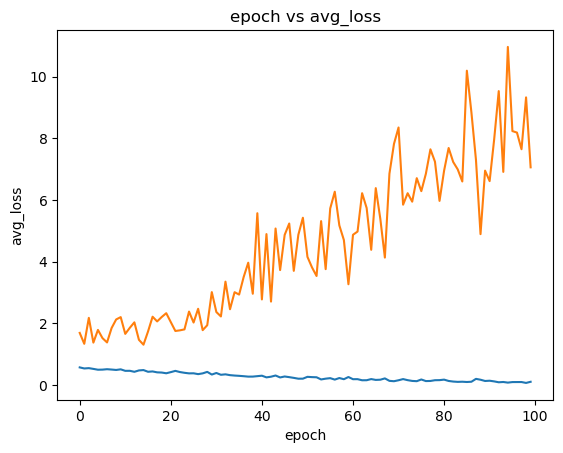

In [92]:
plt.plot(train_loss_ep)
plt.plot(valid_loss_ep)
plt.xlabel('epoch')
plt.ylabel('avg_loss')
plt.title('epoch vs avg_loss')

plt.show()

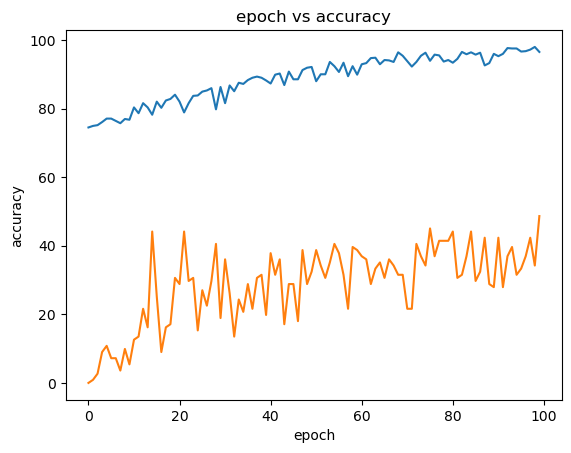

In [93]:
plt.plot(train_accu_ep)
plt.plot(valid_accu_ep)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('epoch vs accuracy')

plt.show()

In [465]:
# verify loss @ init.
# beginning loss = 0.296
# -log(1/2) = 0.3

In [89]:
def load_and_save(load_folder, save_folder, i, no_graph_a, no_graph_b, layer_number): 
    
    # doesn't need to be plus 1 as load_graph pluses one
    g_a, g_b = load_graph(load_folder, i+1, no_graph_a, no_graph_b, layer_number)
    
    solution = lap_solver(g_a, g_b)
    
    #saves the solution as plus one
    save_solution(save_folder, 
                  f'e{i + 1}_Ga{no_graph_a+1}_Gb{no_graph_b+1}_l{layer_number}',
                  solution)
    
    

In [109]:
# for single_no,single in enumerate(single_train_loader): 
#     print(single_no, single.y.item())

    # count = 0 

# for data in single_train_loader: 
    
#     print(count)
#     print(data.y.item())
#     count += 1
    
# 662 is where the ones start

# single_train_loader has size 889 because it a loader of the train_dataset

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [110]:
random_zero = random.sample(range(1, 660), 5)
random_one = random.sample(range(665, 889), 5)

#tens = random_zero + random_one

tens = [238, 143, 151, 34, 63, 699, 724, 802, 852, 779]

print(tens)


[238, 143, 151, 34, 63, 699, 724, 802, 852, 779]


In [112]:
load_folder = 'Protein_Model'
save_folder = 'tens_LAP_solutions'
make_folder(save_folder)

pool = mp.Pool(mp.cpu_count())

# this should, for every epoch we have trained on (100)
# save every lap solution for every combination of graphs in the tens array

# currently not saving for 1015, 940
for i in range(100): 
    
    for first in tens:
        
        for second in tens:
    
            pool.apply_async(load_and_save, 
                             args=(load_folder,
                                   save_folder, i, first, second, 1))

#callback?
                     
pool.close()



In [111]:
# code to delete folders and their contents 

import shutil 

shutil.rmtree('DIRECTORY NAME')

In [93]:
def load_solution(folder_name, file_name): 
    
    file_path = folder_name + '/' + file_name + '.npz'
    
    loaded_solution = load_npz(file_path)
    
    return loaded_solution

In [95]:
def load_laps(folder_name, epoch, no_graph_a, no_graph_b, layer_number): 
    
    solution = 
    load_solution( folder_name,
                  f'e{epoch}_Ga{no_graph_a+1}_Gb{no_graph_b+1}_l{layer_number}')
    
    return solution

In [114]:
#TESTING CODE 

#load_solution('LAP_solutions', 
              #f'e1_Ga13_Gb16_l2')


#load_and_save(load_folder, save_folder, 1, 117, 1015, 1)

# print(
#     load_laps('tens_LAP_solutions', 
#           2, 
#           238, 
#           143,
#           1)
# )          

In [147]:
def average_lap(folder_name, no_graph_a, no_graph_b, layer_number): 
    
    result = 0.0
    
    for i in range(99): 
        
        solution = load_laps(folder_name, 
                             i+1, 
                             no_graph_a, 
                             no_graph_b,
                             layer_number)
        
        
        result += solution
        
    
    plt.matshow(result.todense())

        
    
    # this method loads the lap solutions and then creates an average graph
    # for the solutions over all epochs 

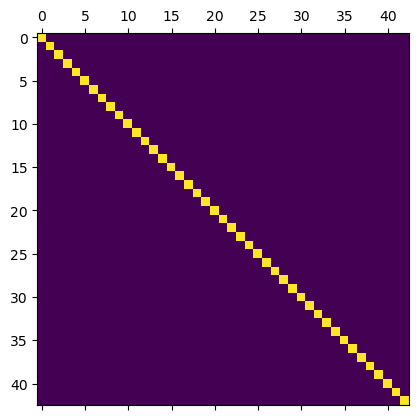

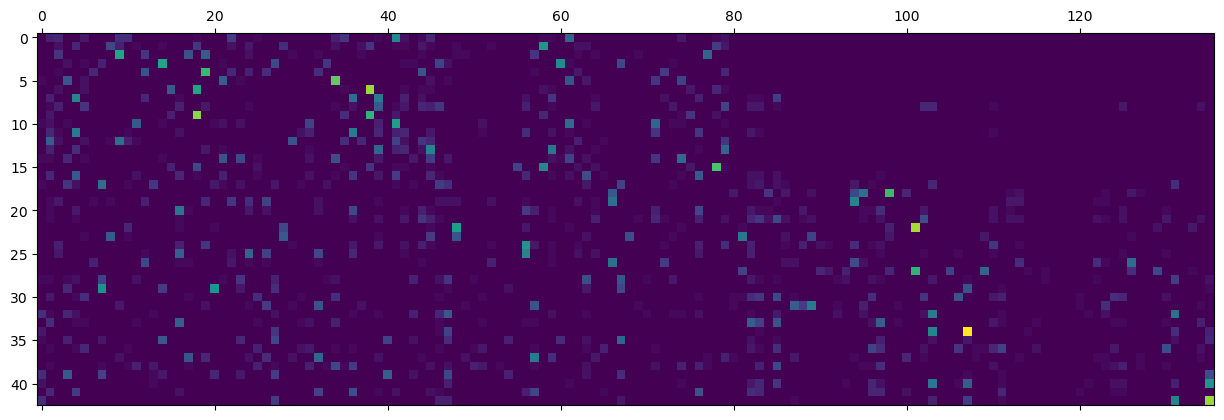

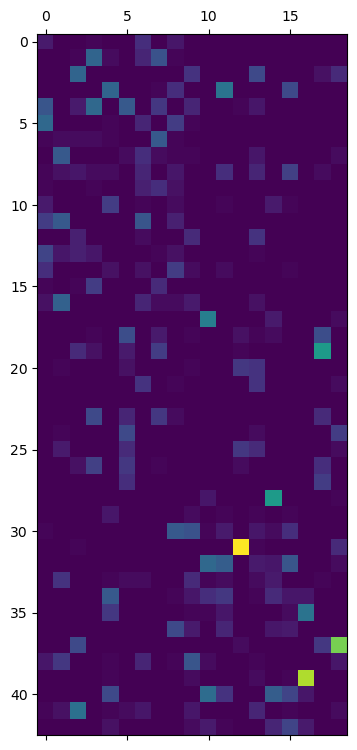

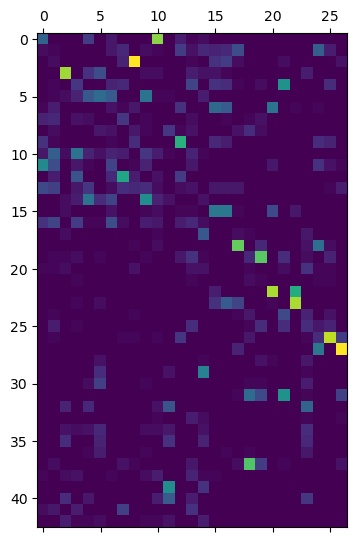

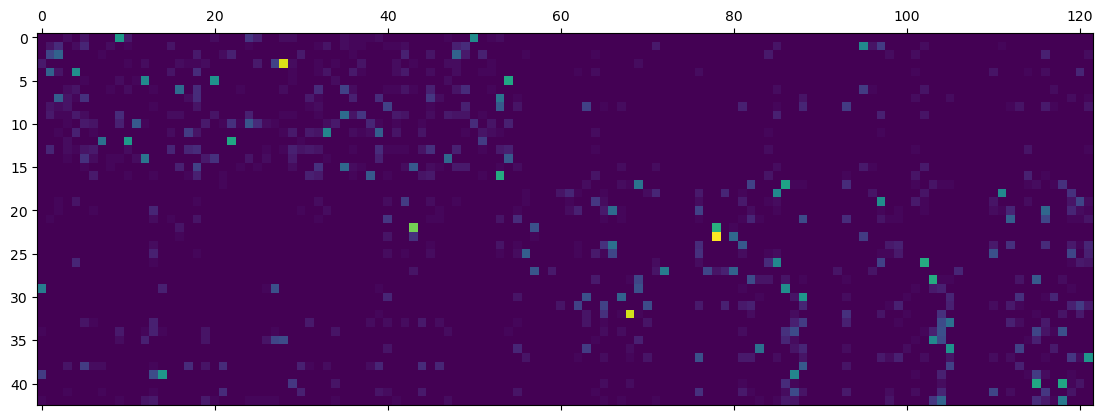

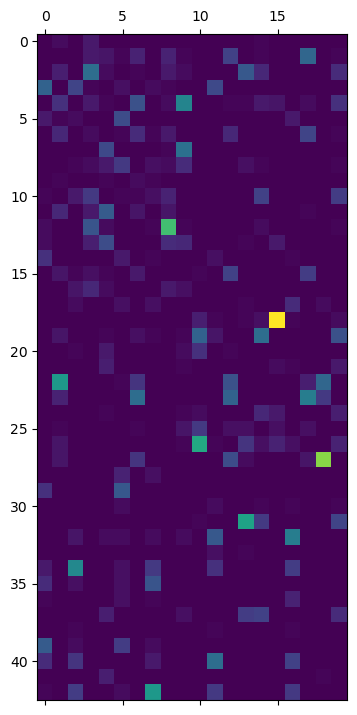

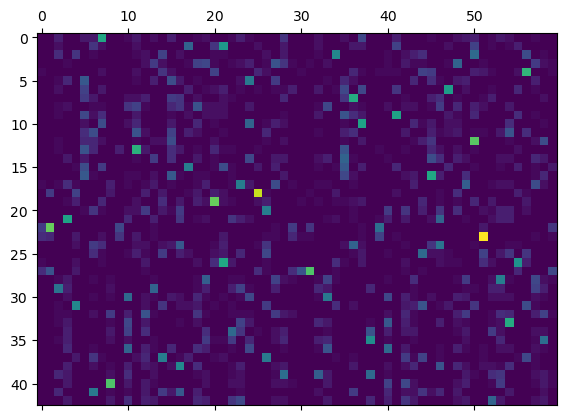

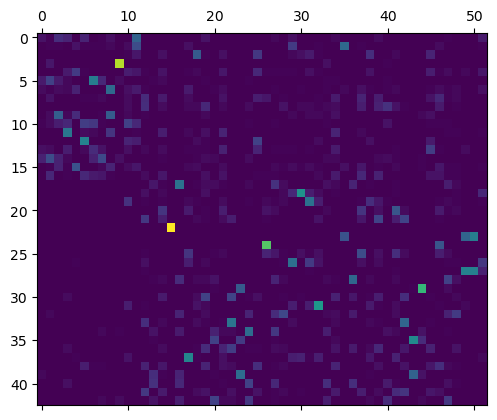

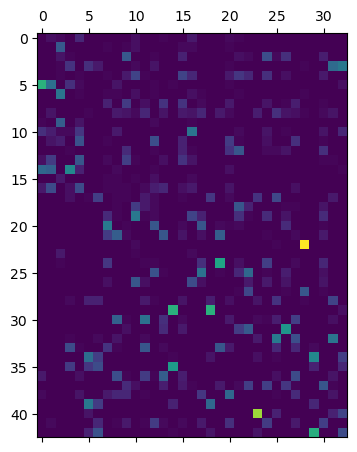

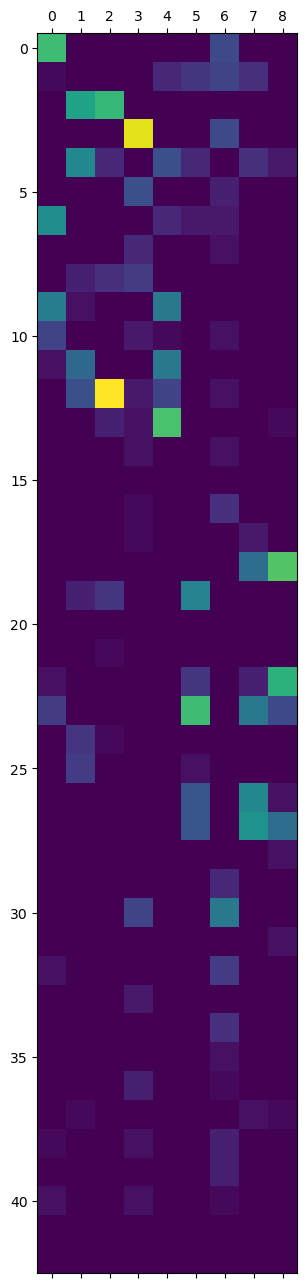

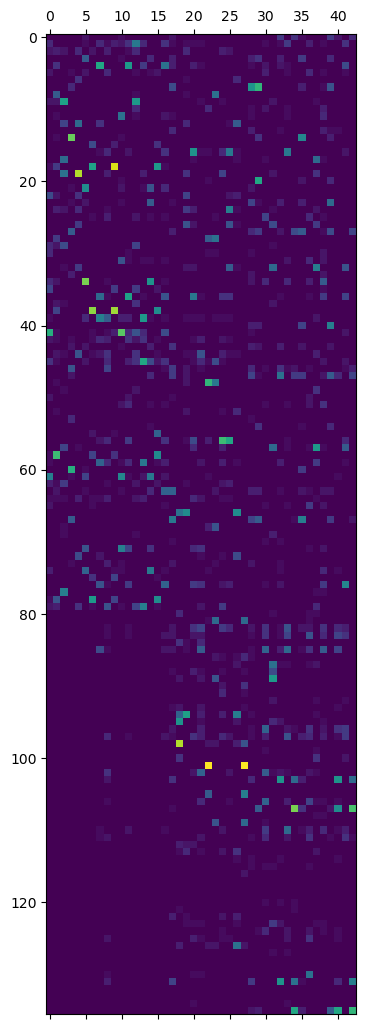

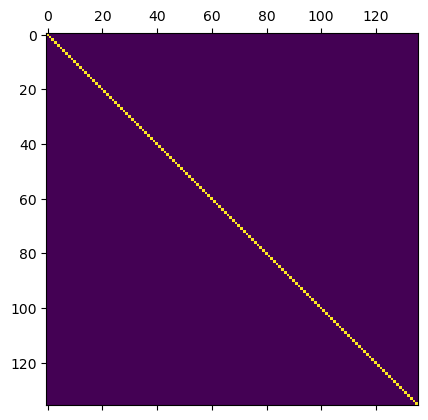

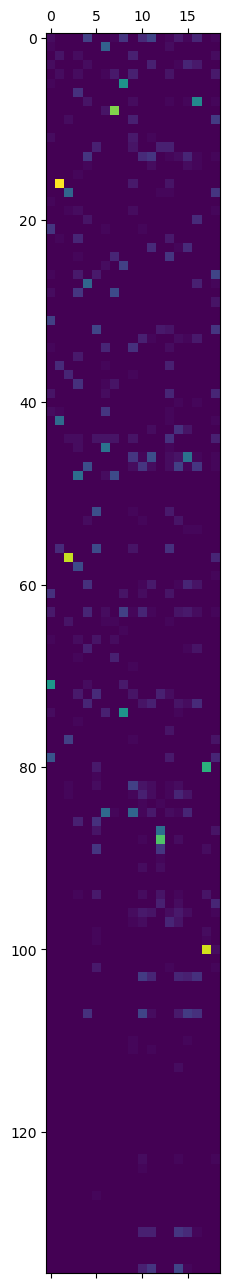

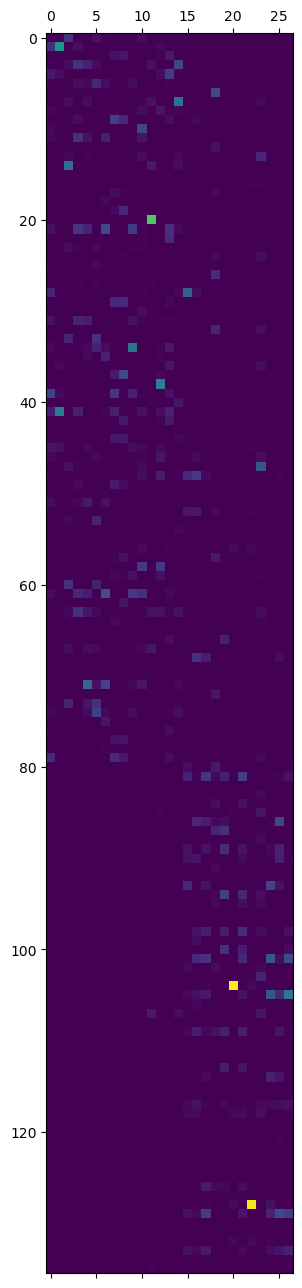

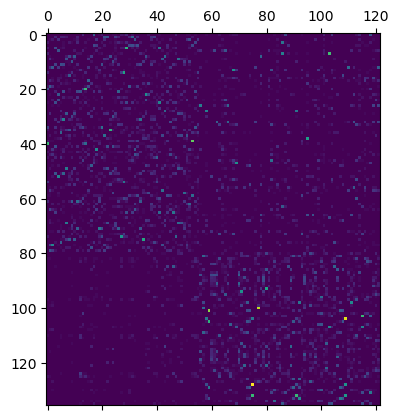

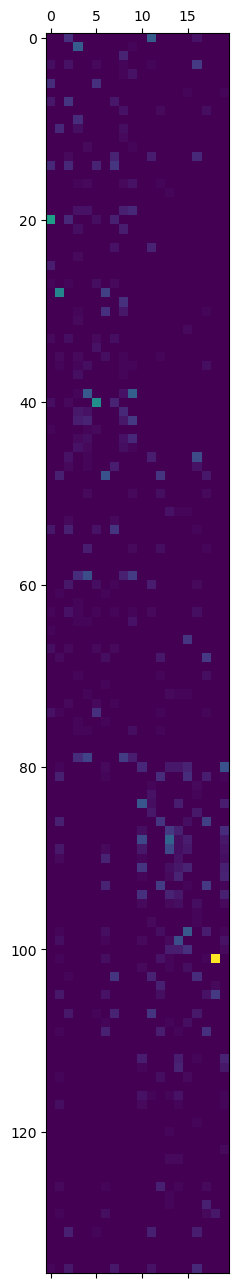

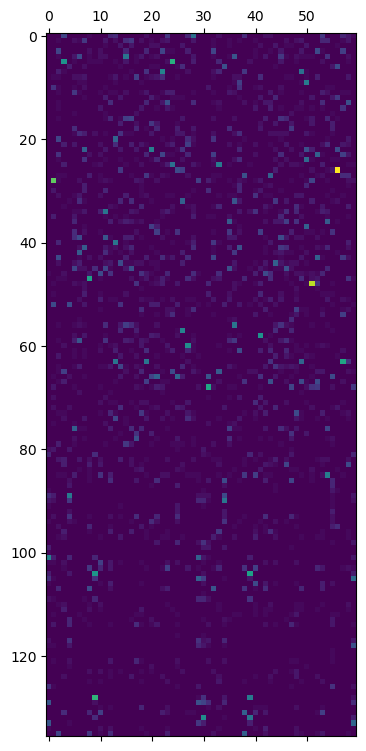

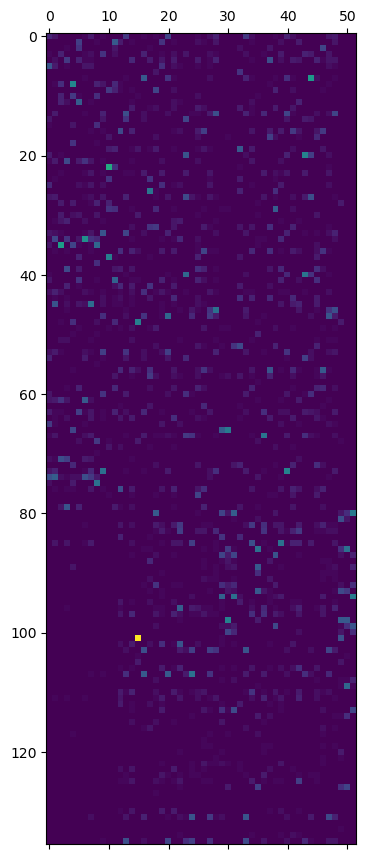

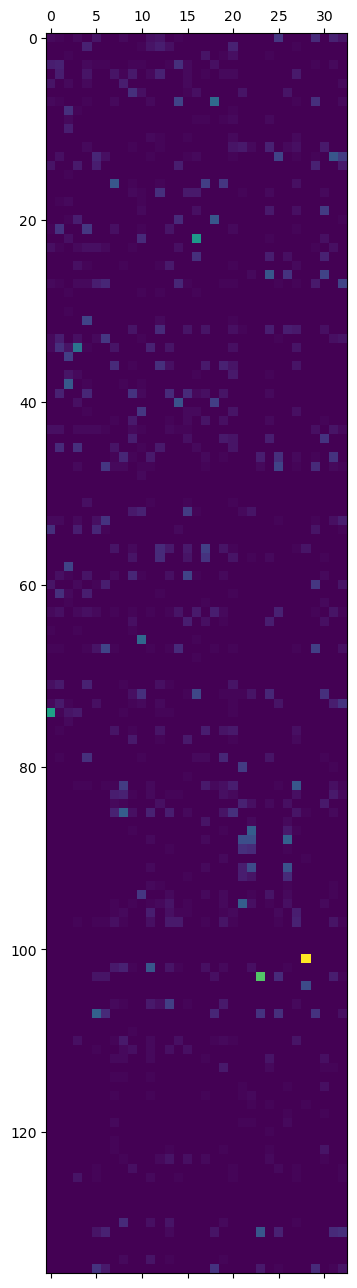

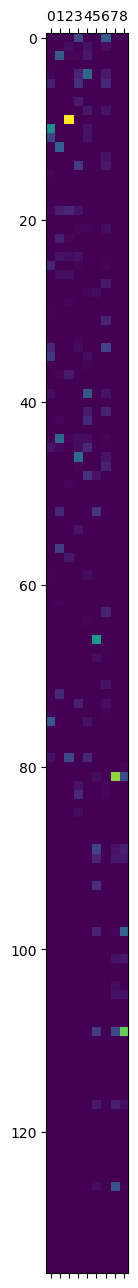

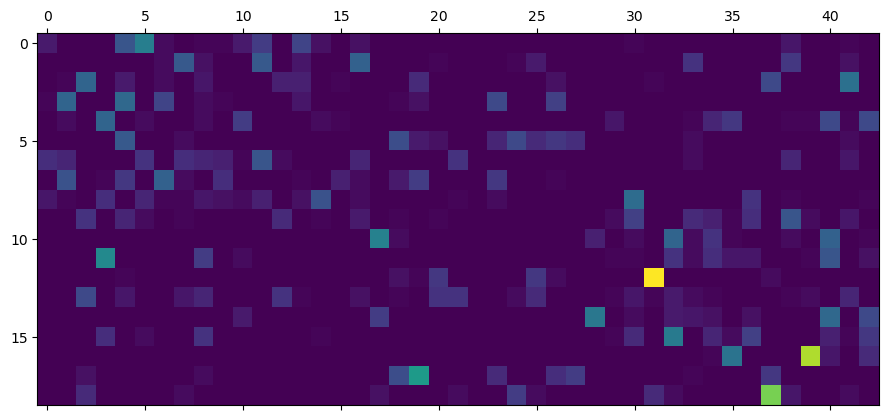

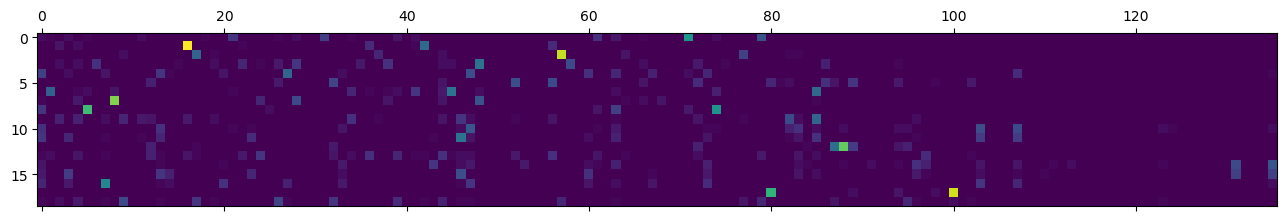

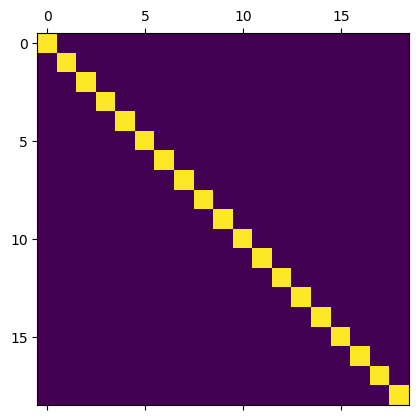

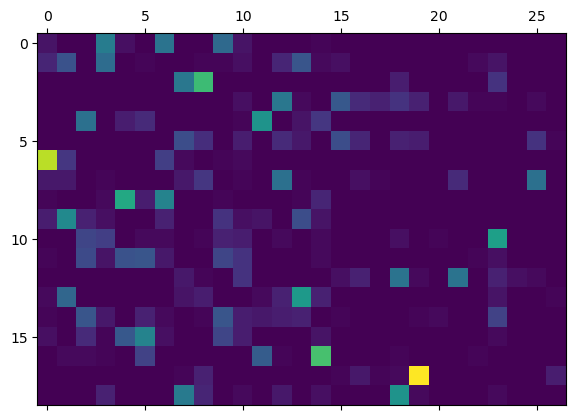

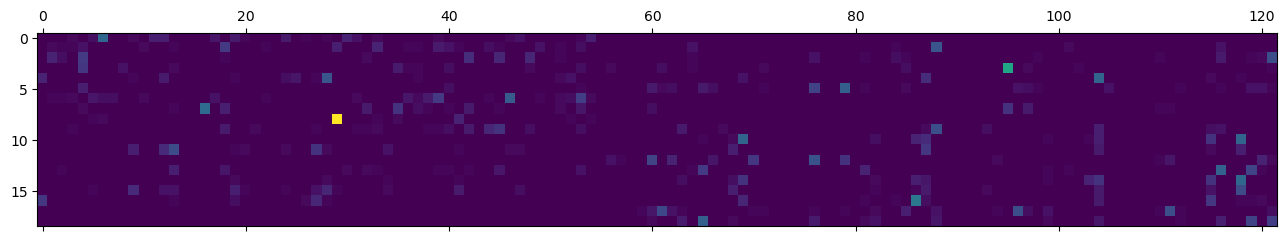

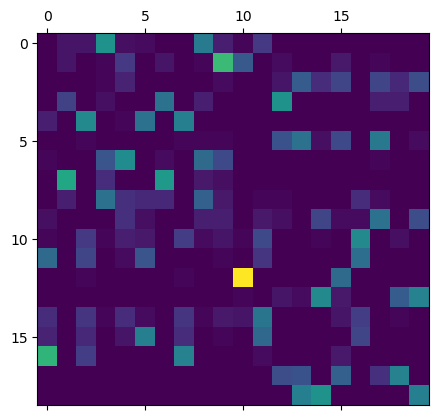

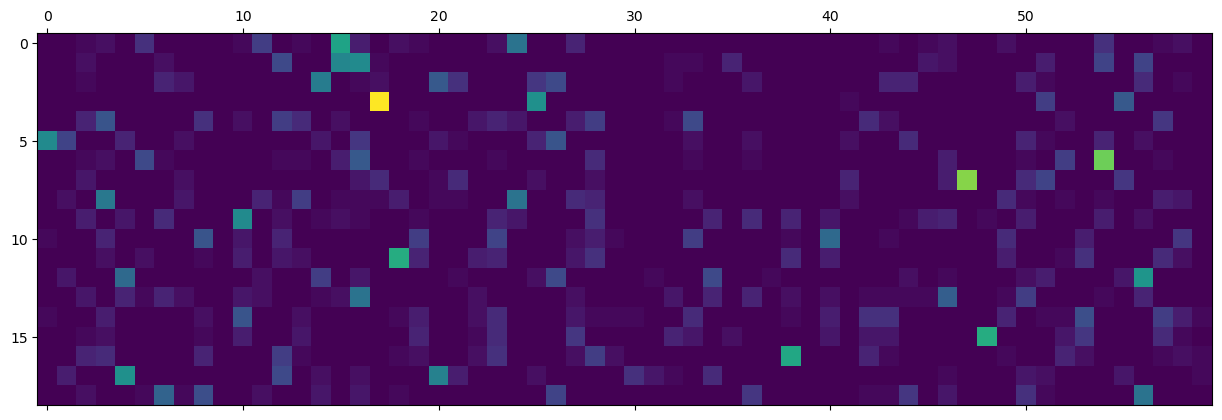

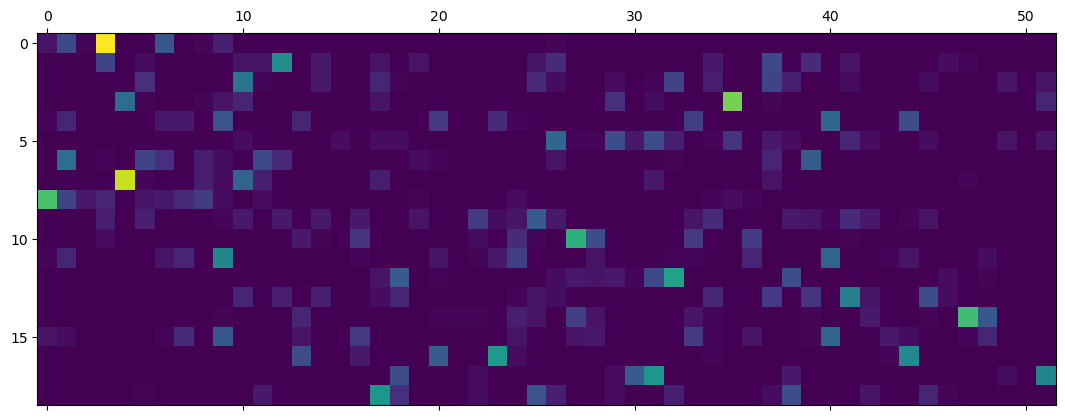

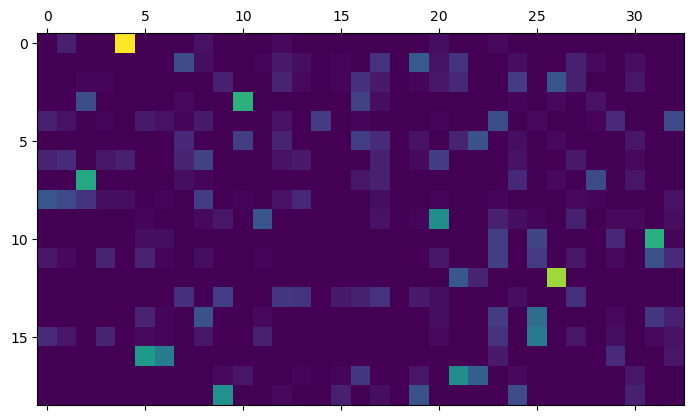

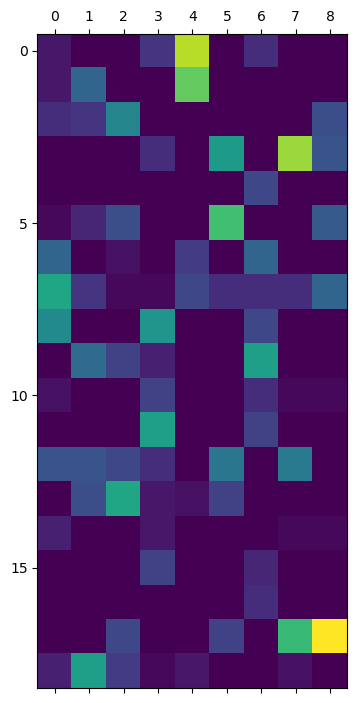

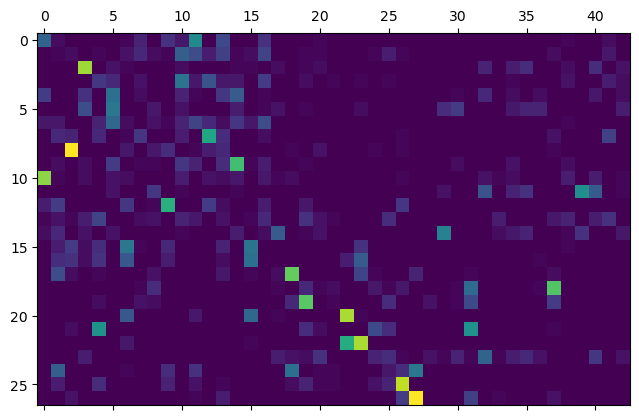

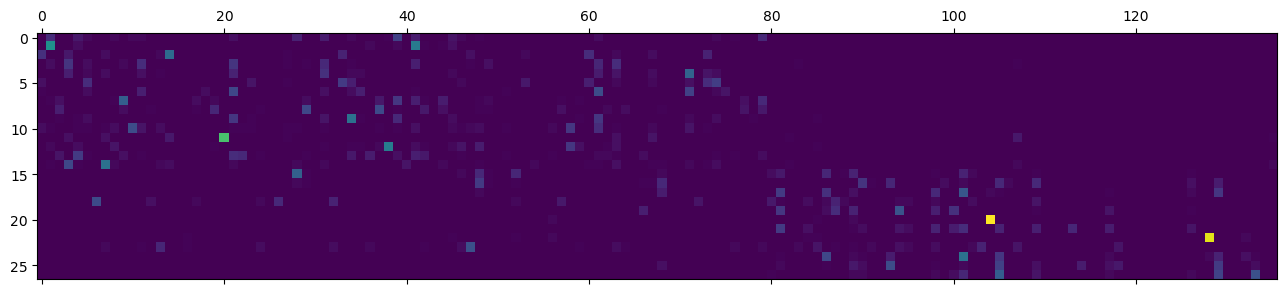

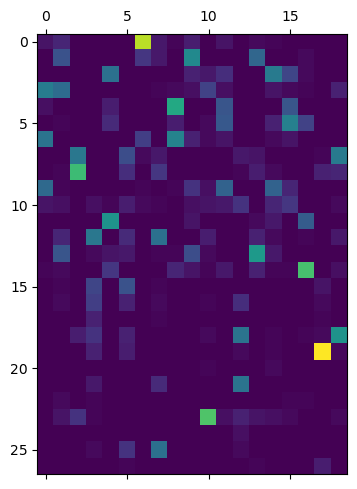

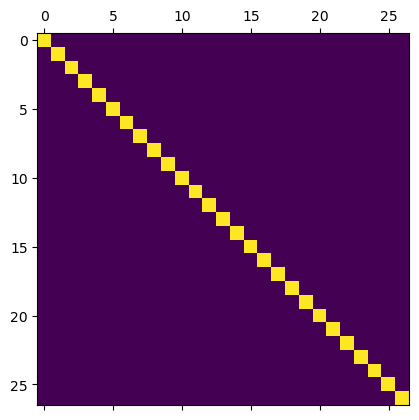

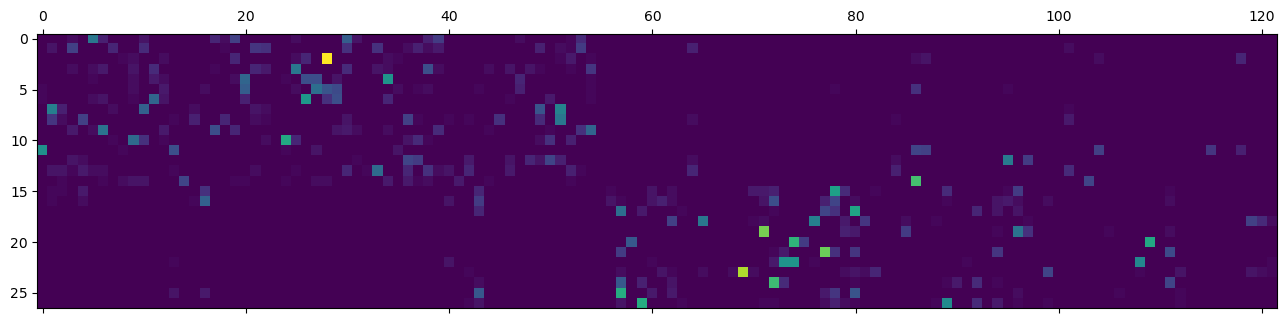

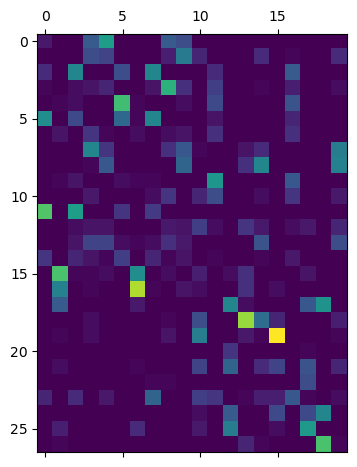

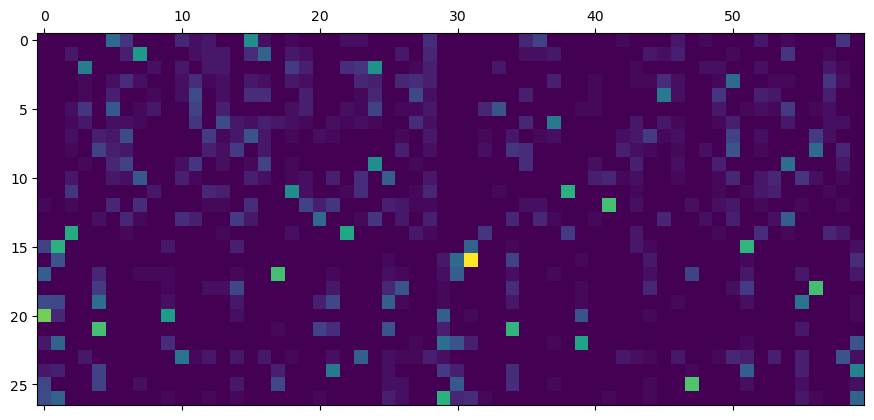

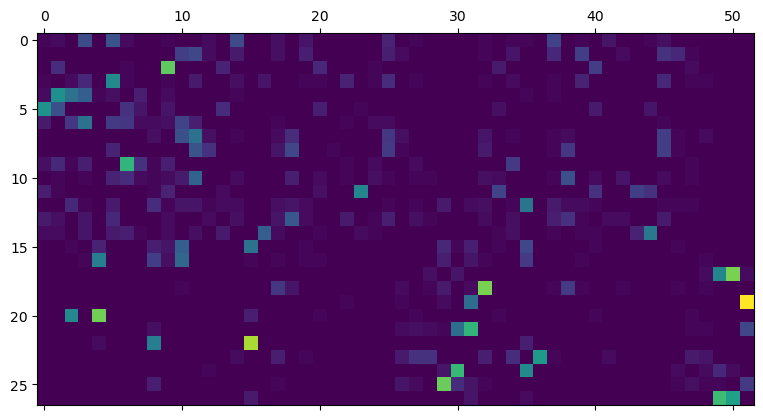

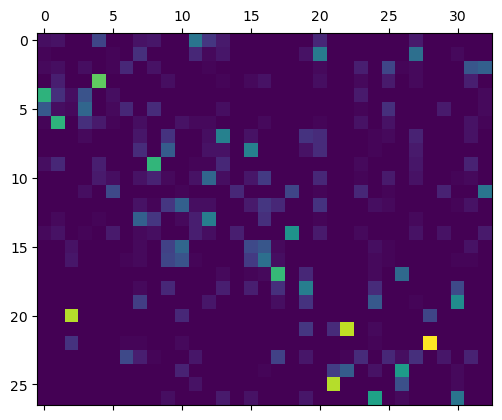

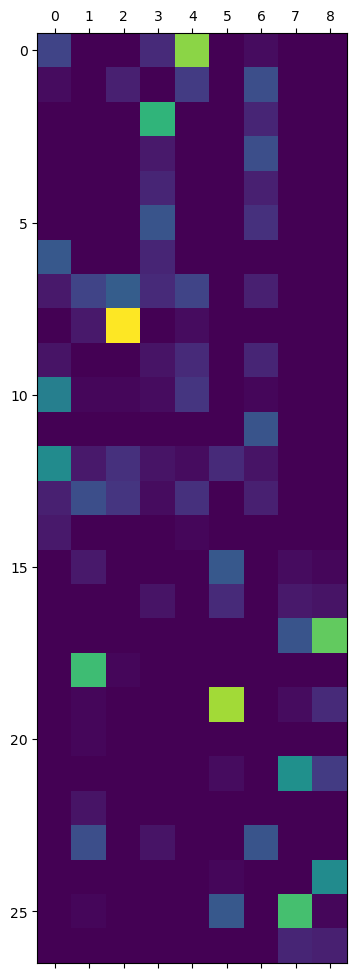

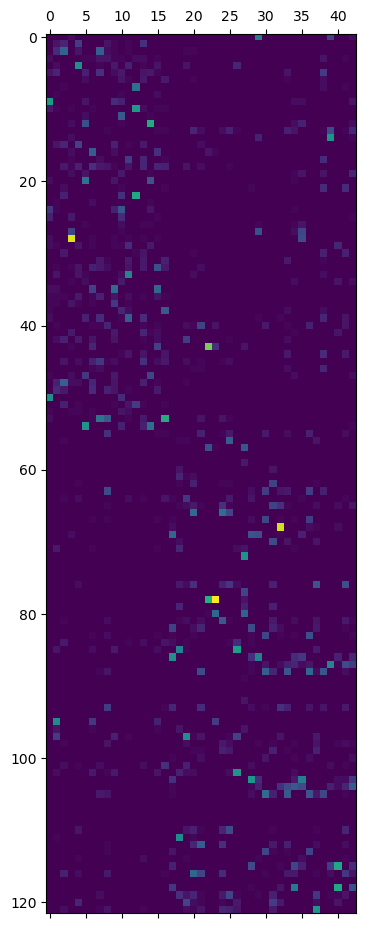

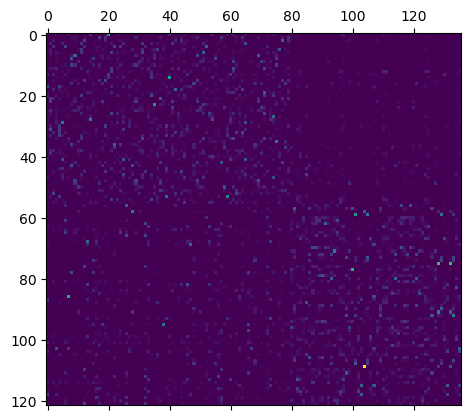

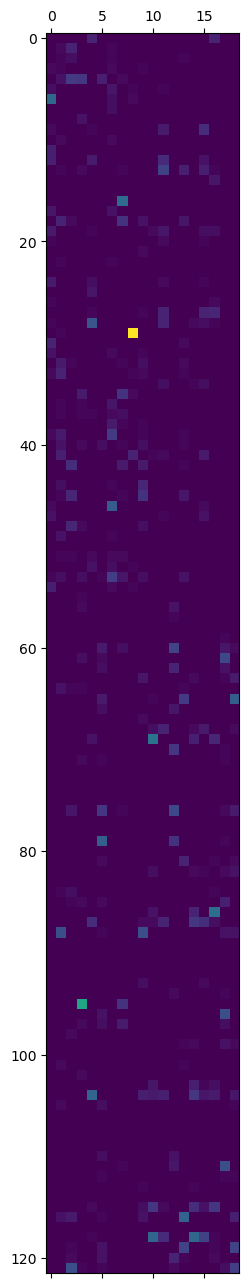

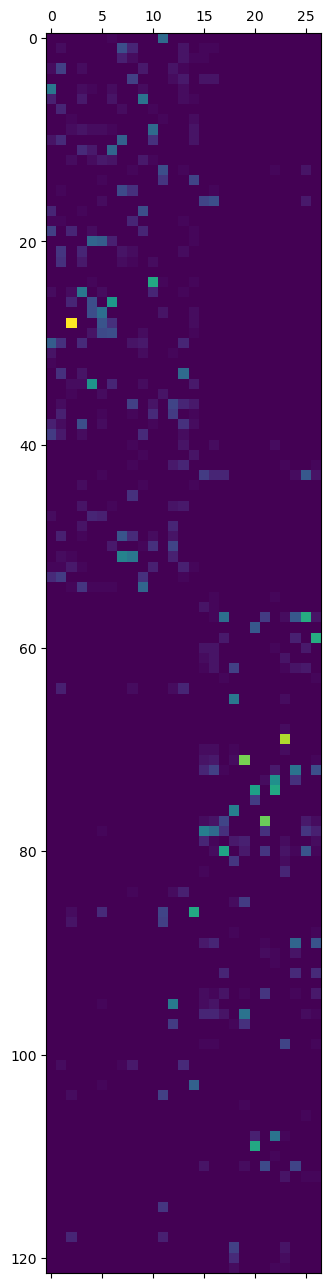

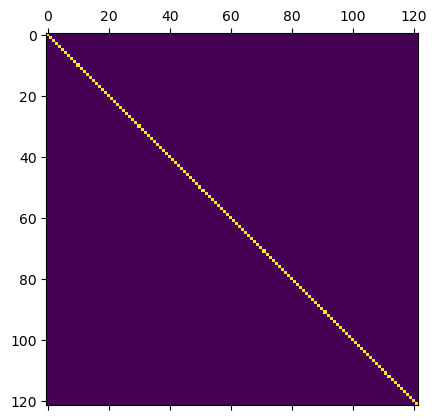

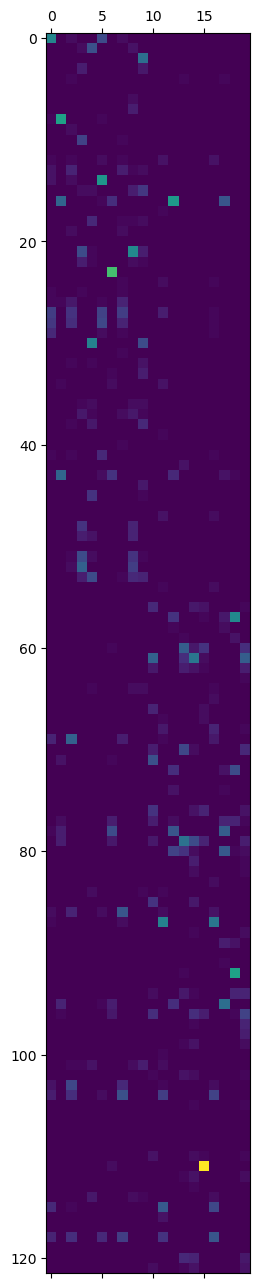

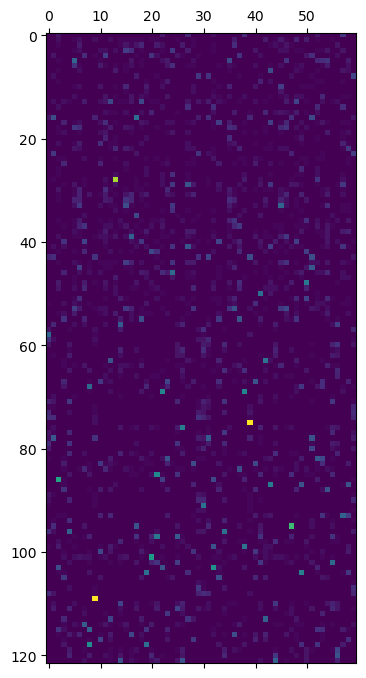

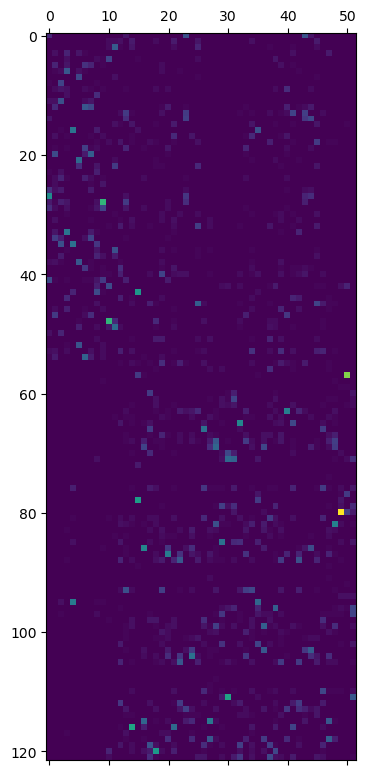

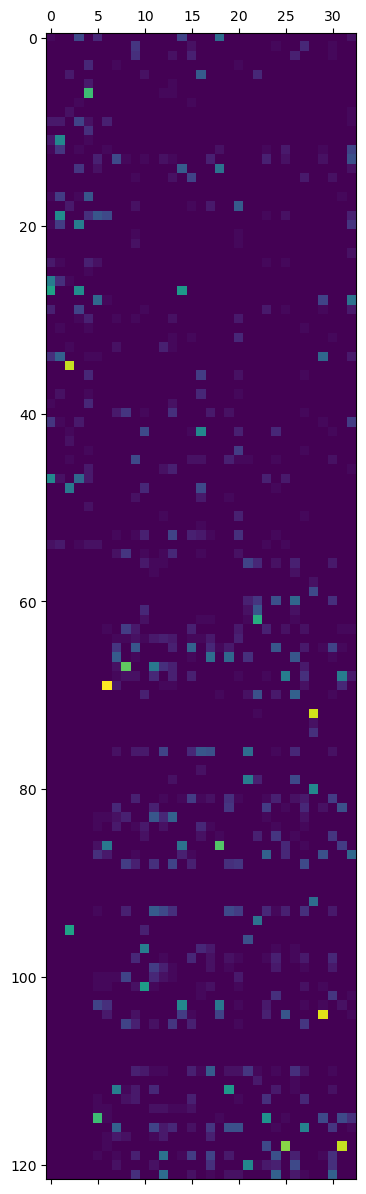

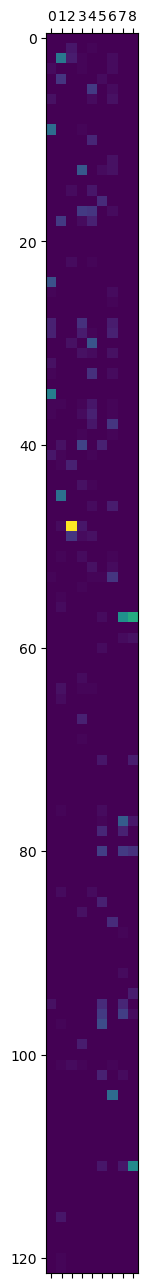

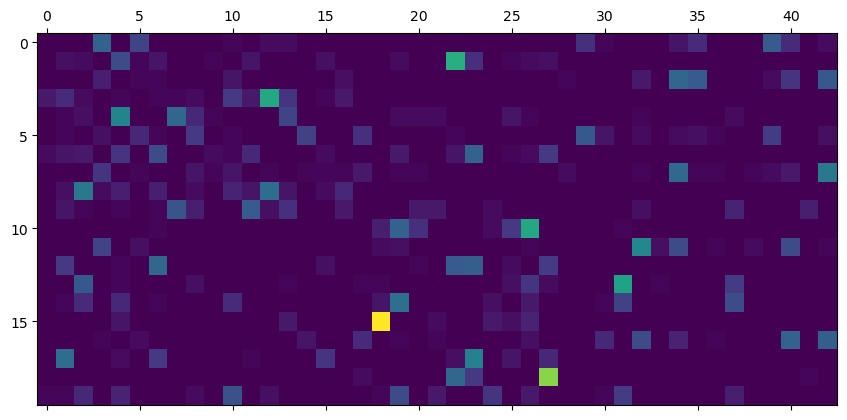

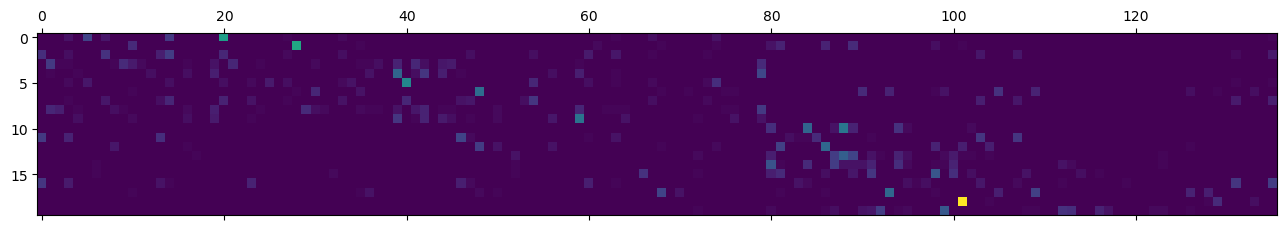

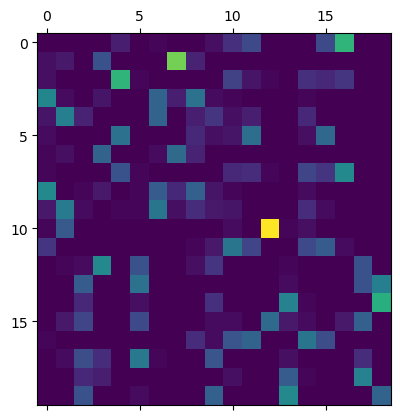

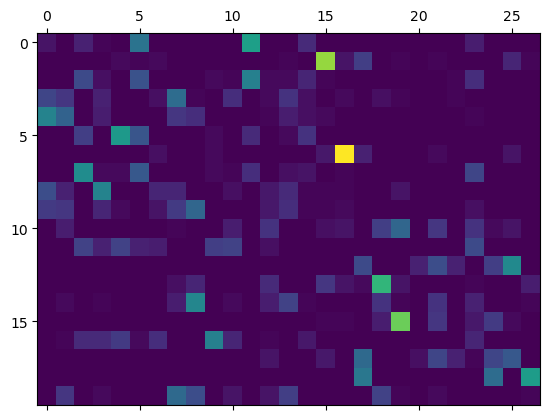

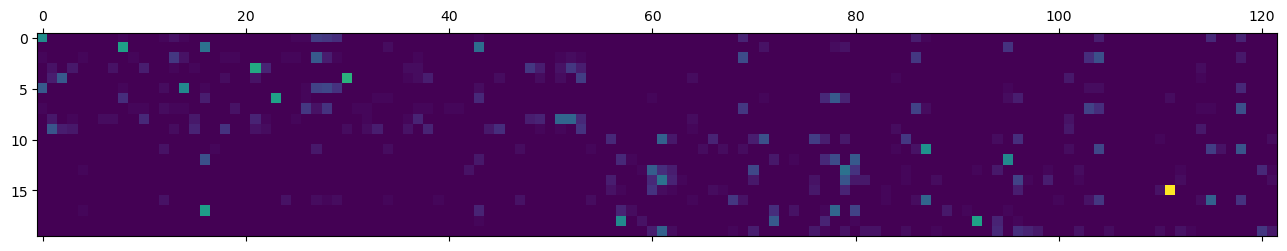

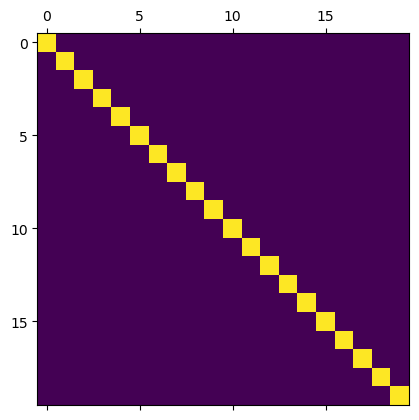

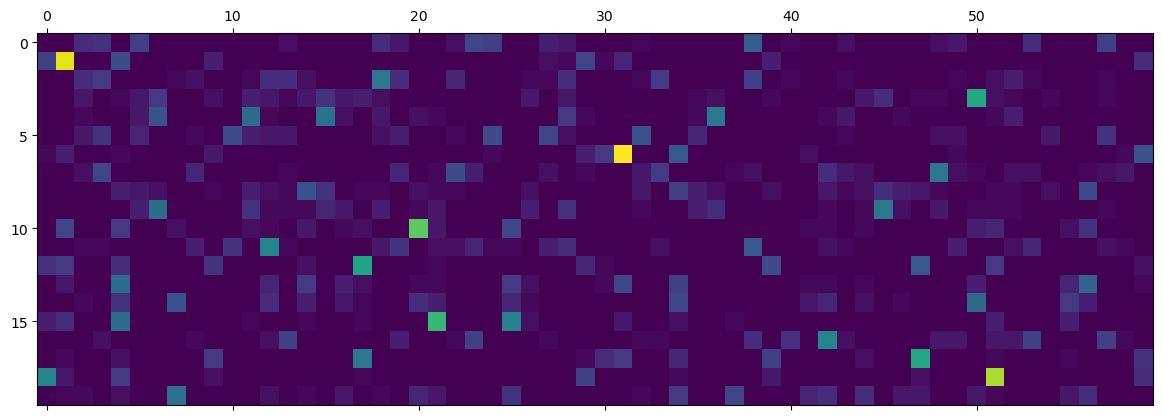

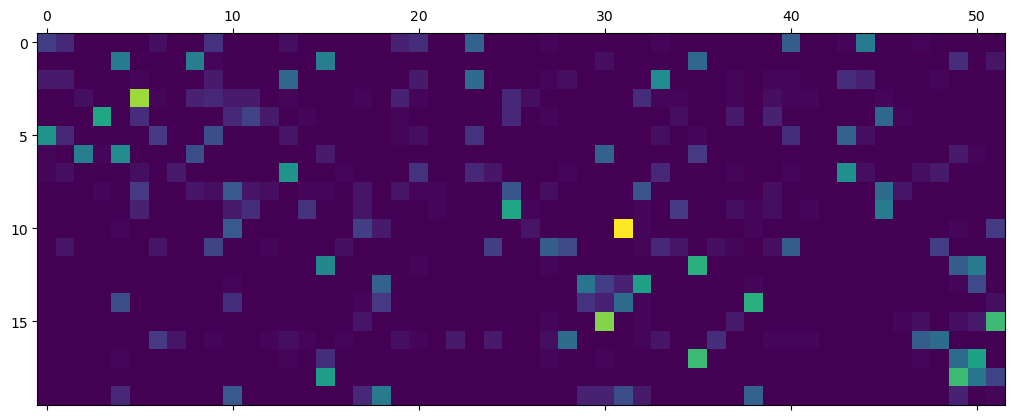

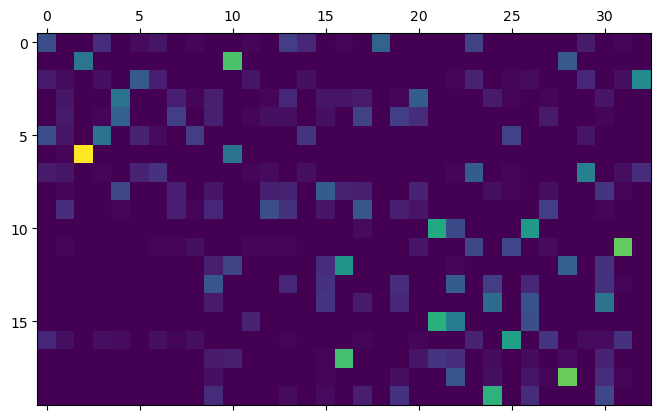

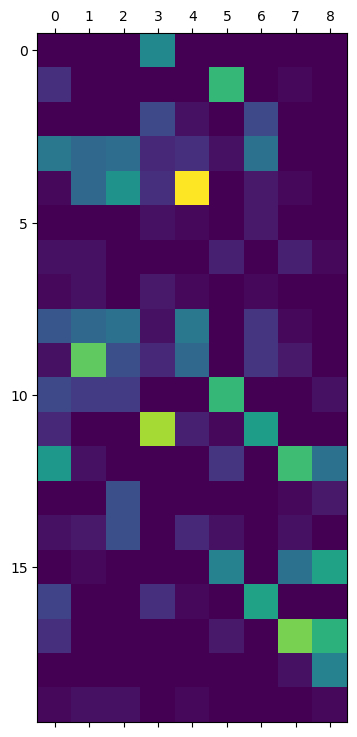

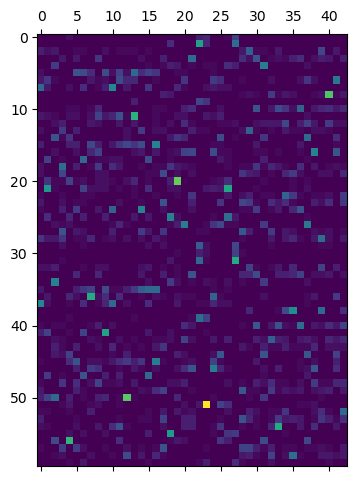

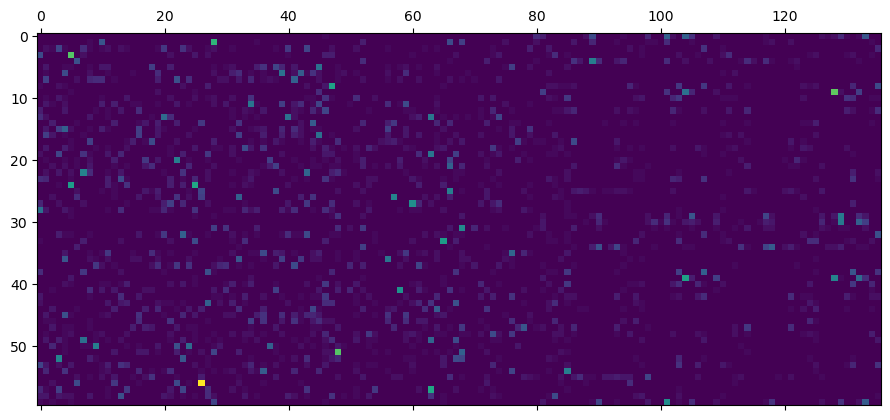

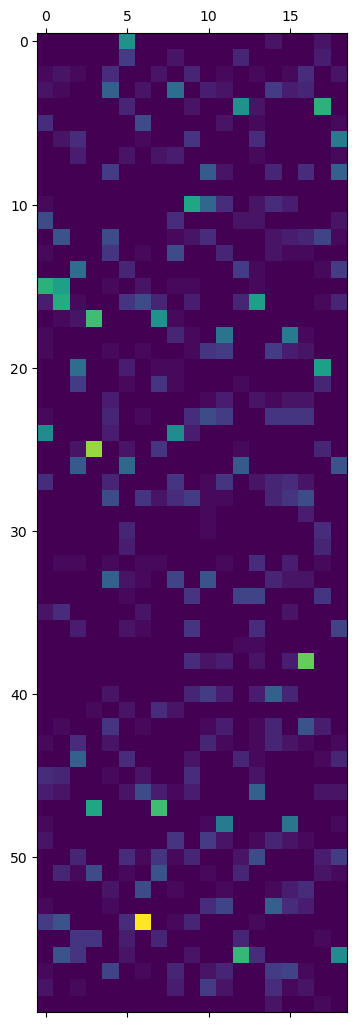

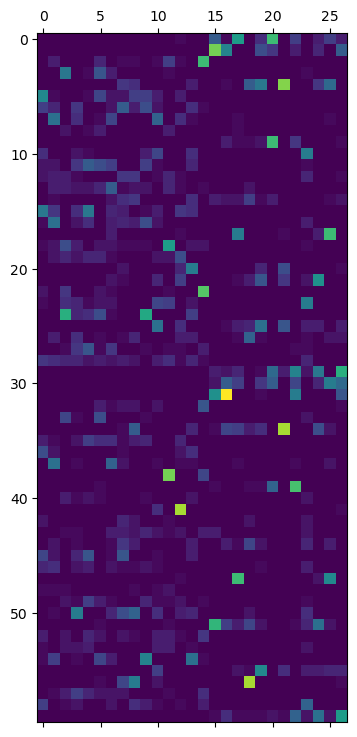

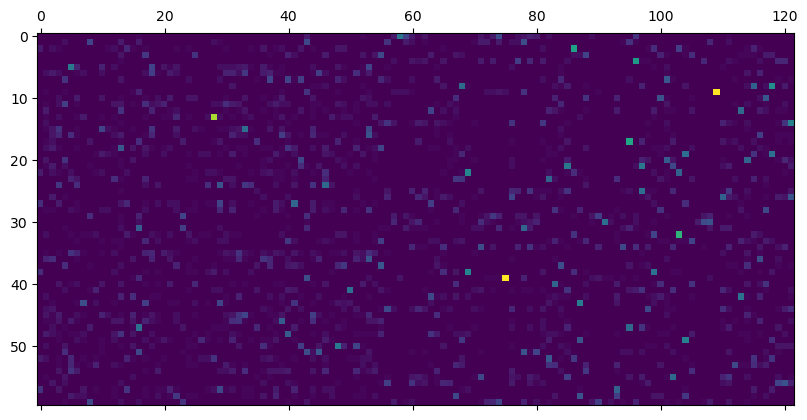

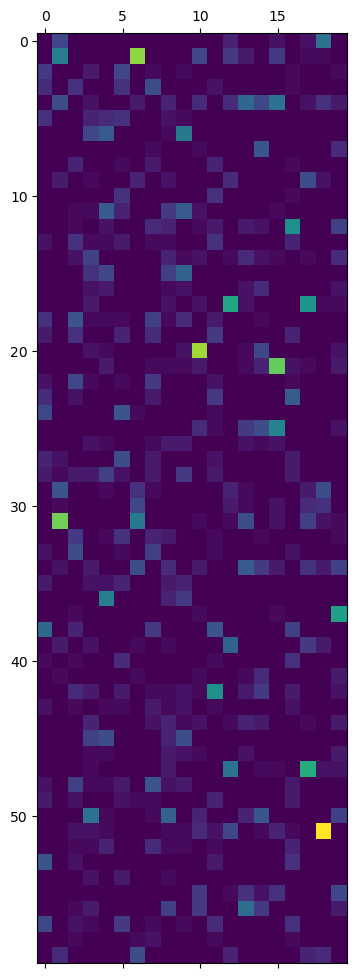

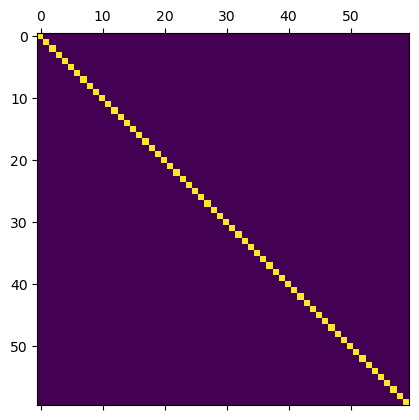

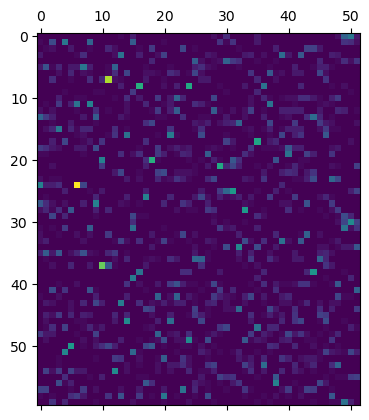

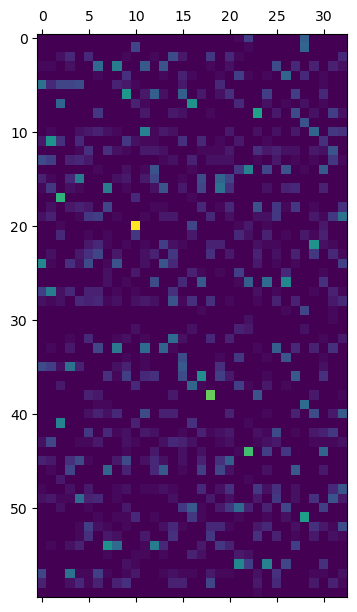

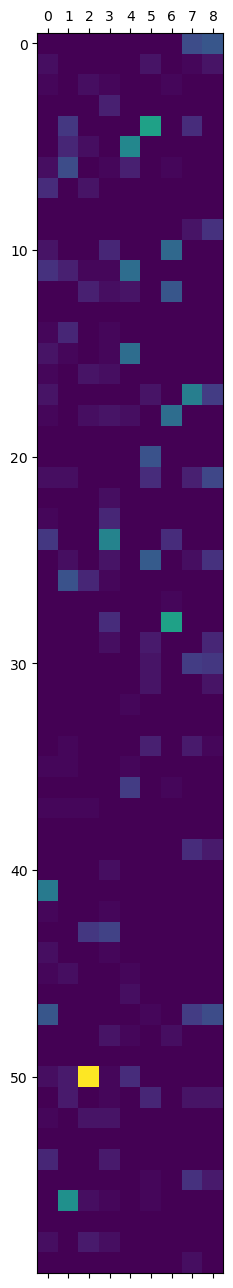

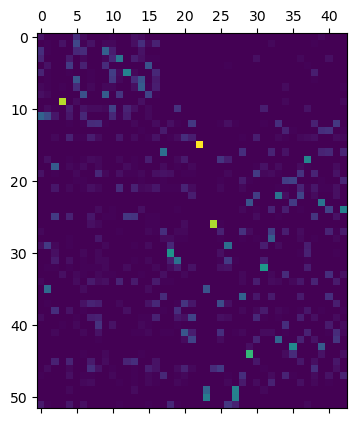

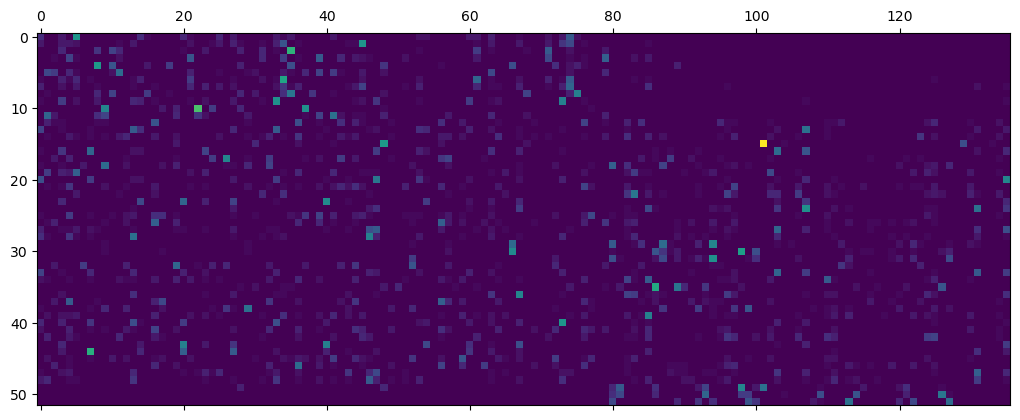

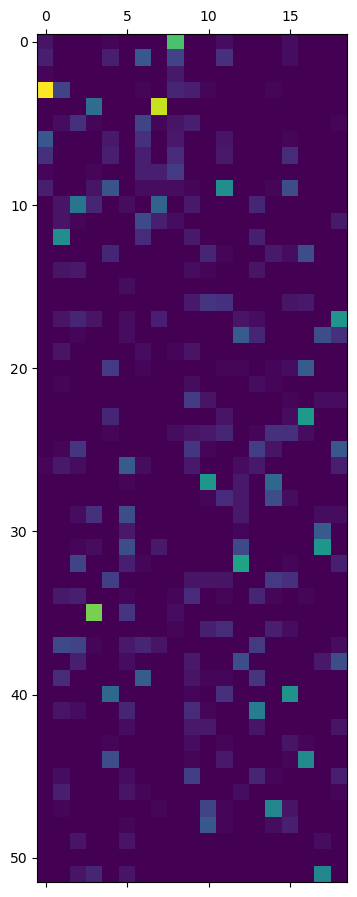

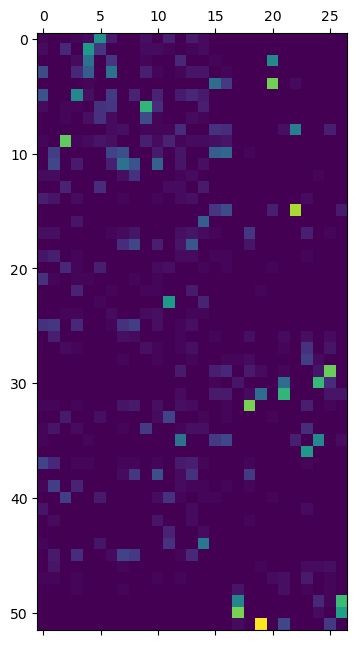

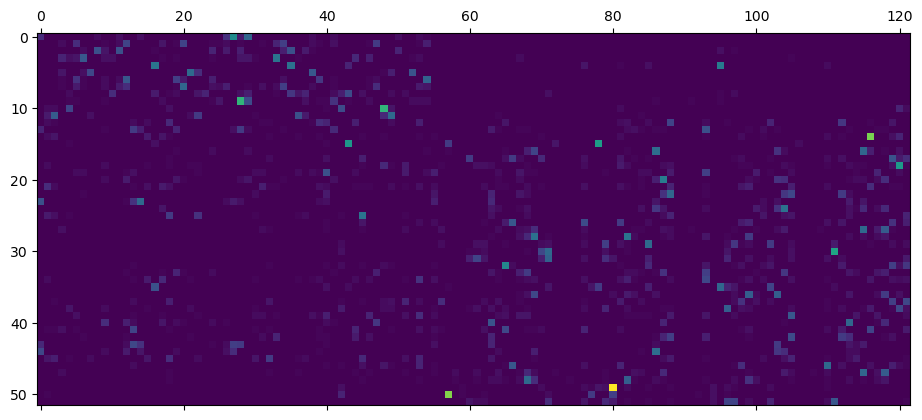

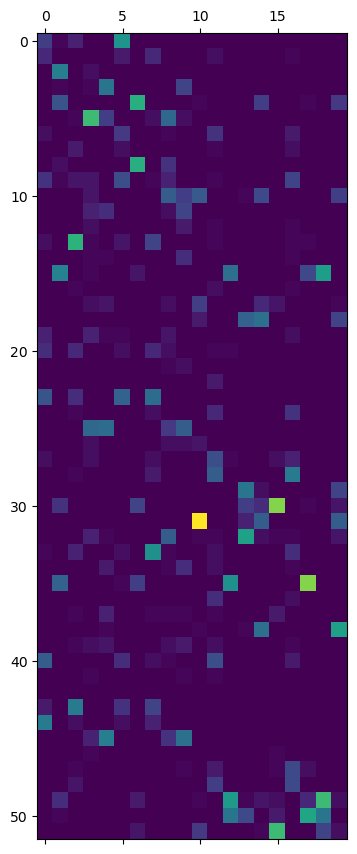

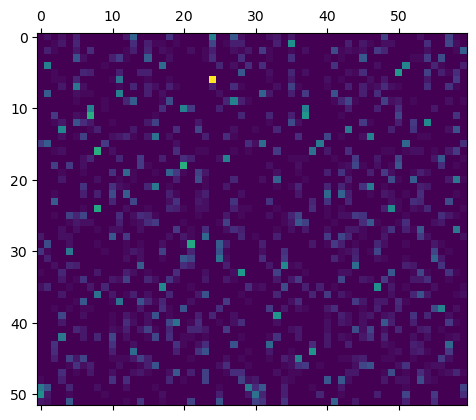

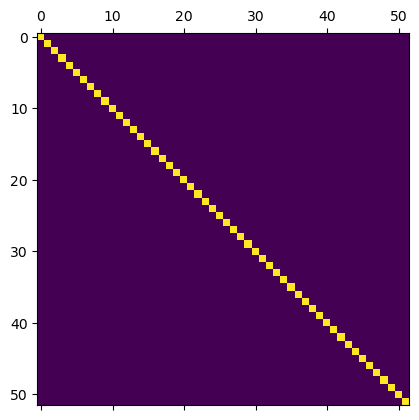

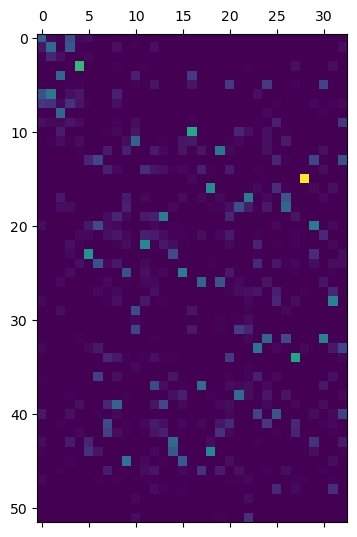

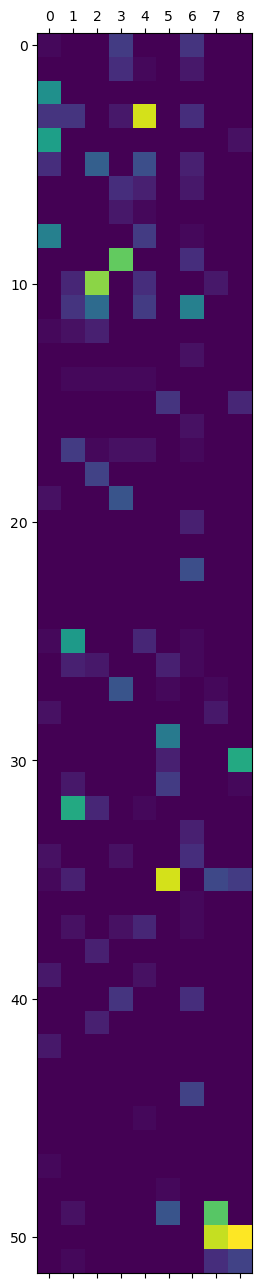

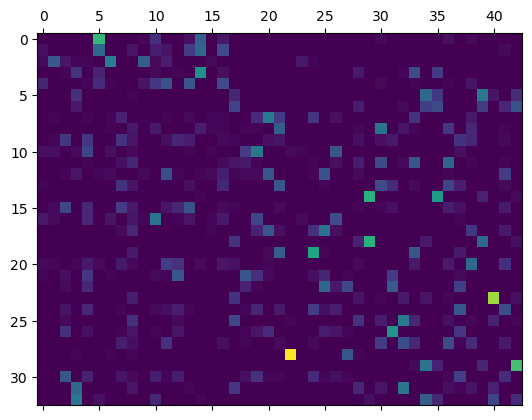

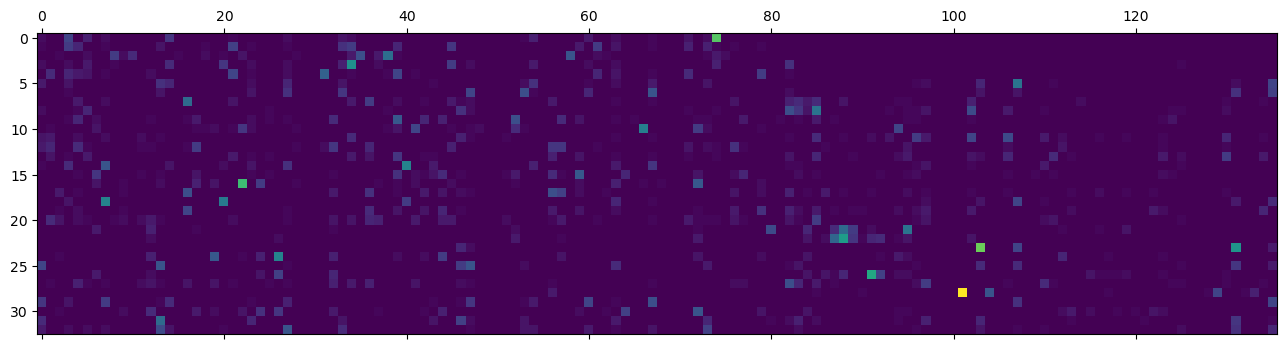

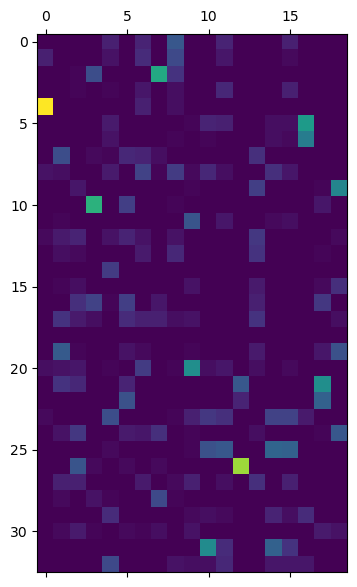

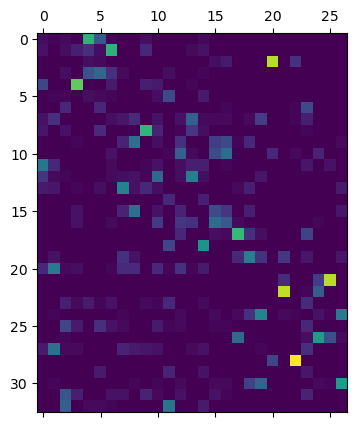

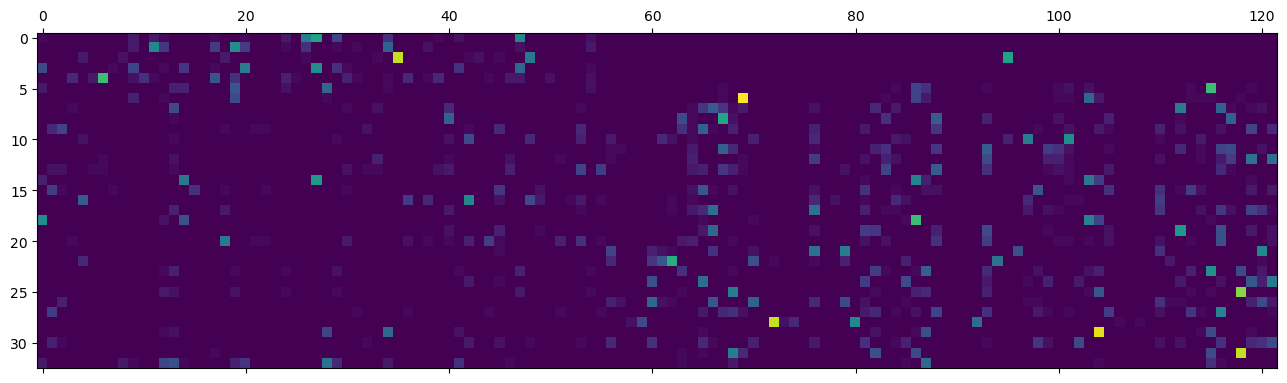

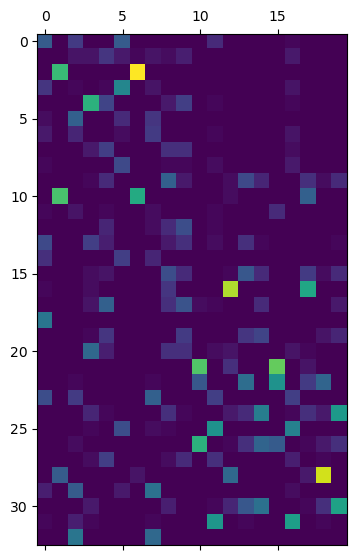

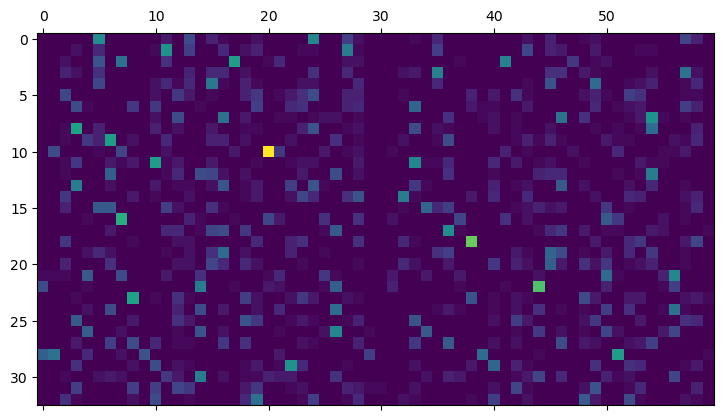

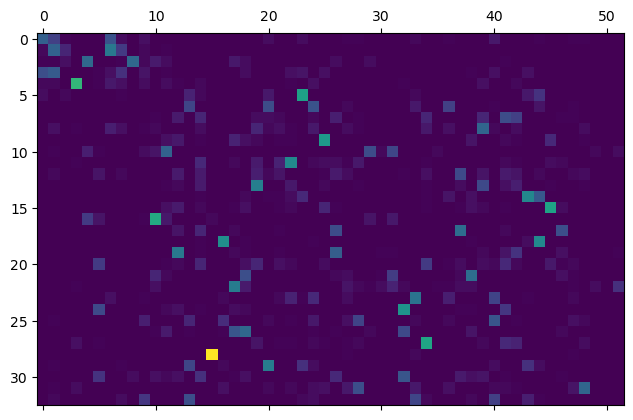

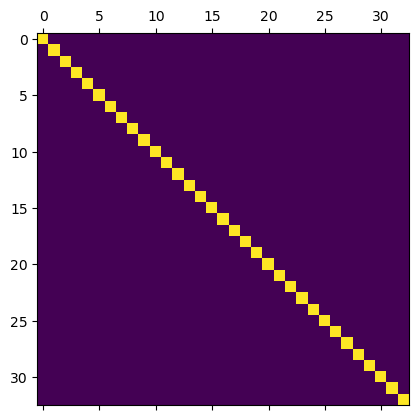

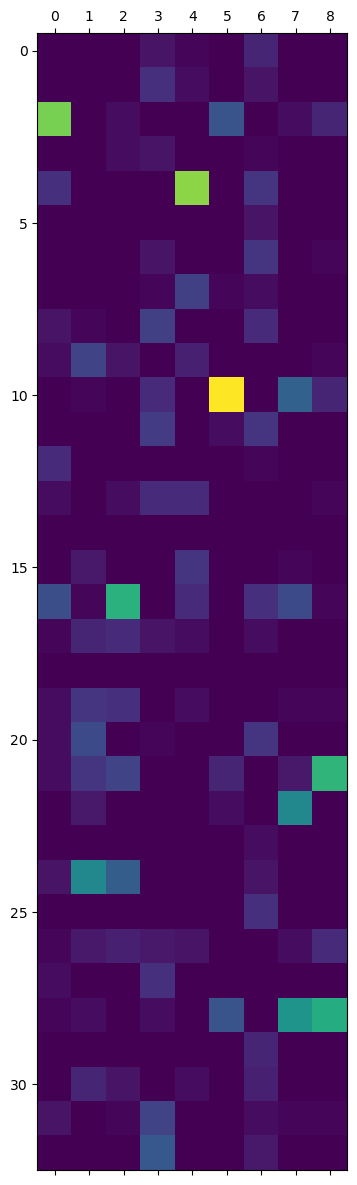

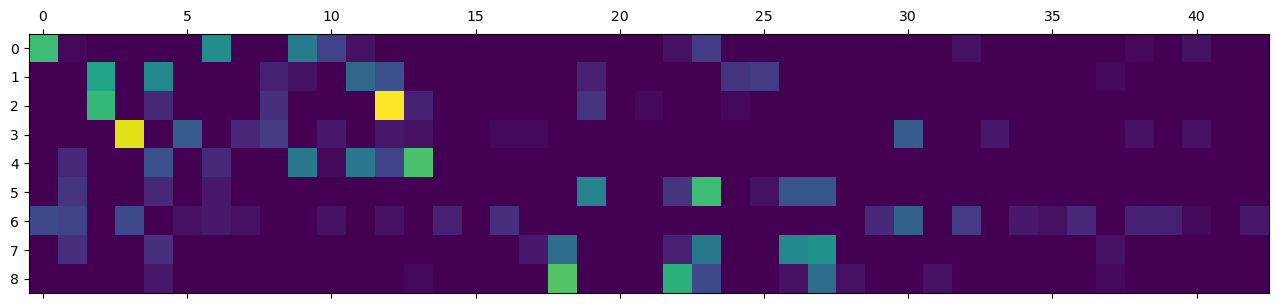

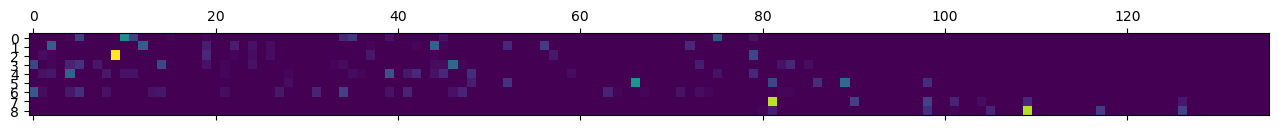

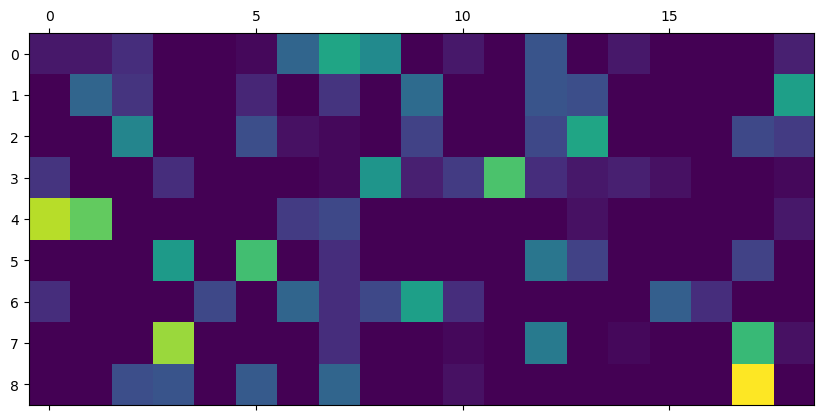

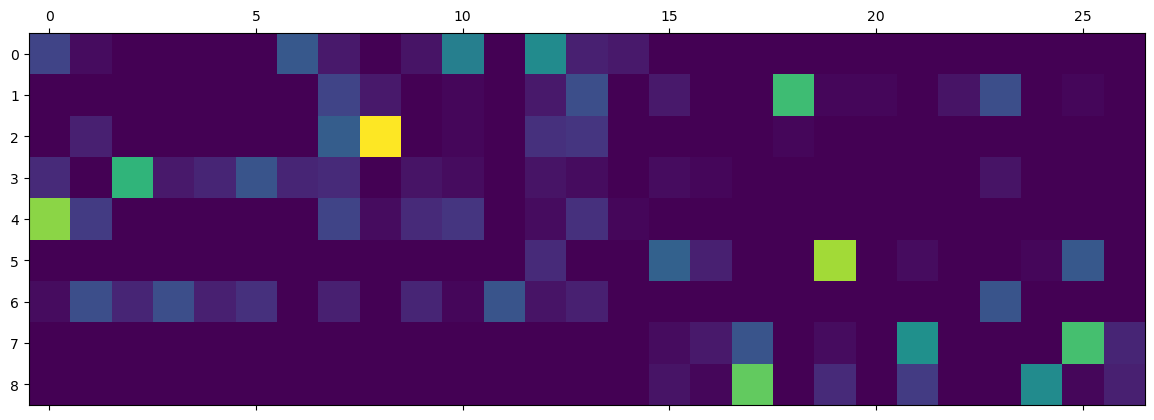

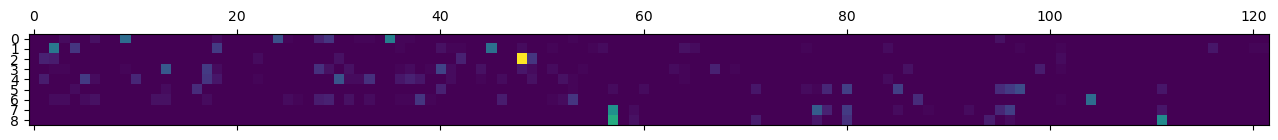

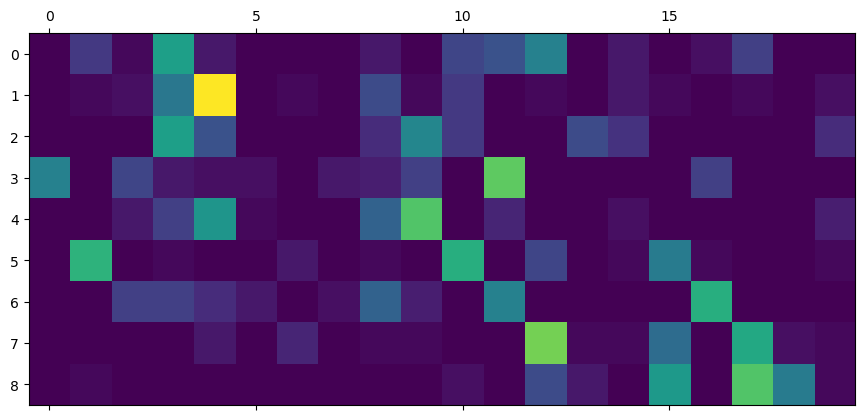

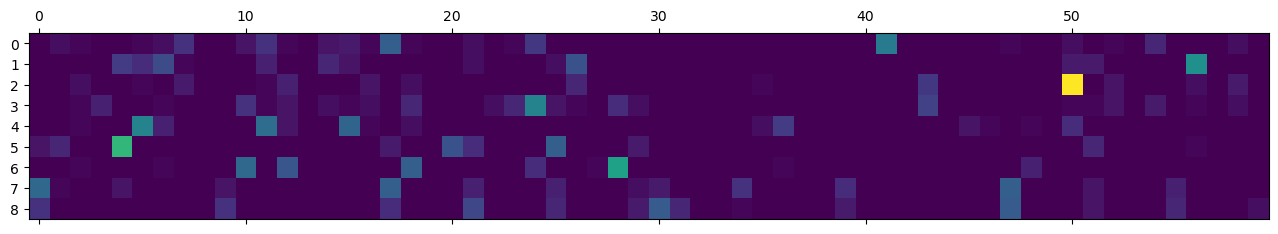

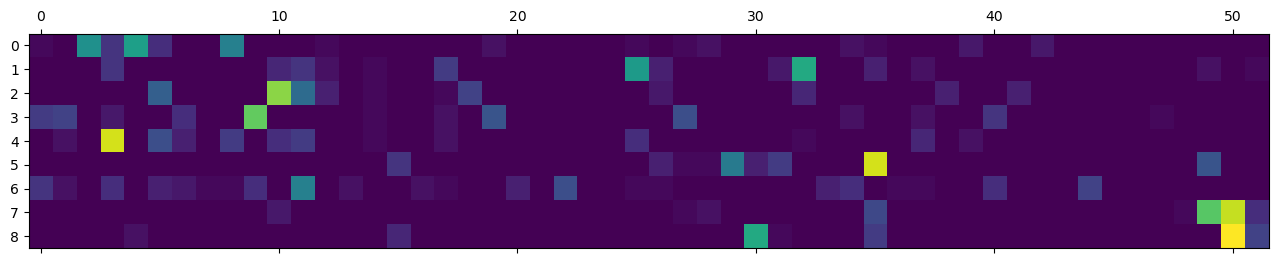

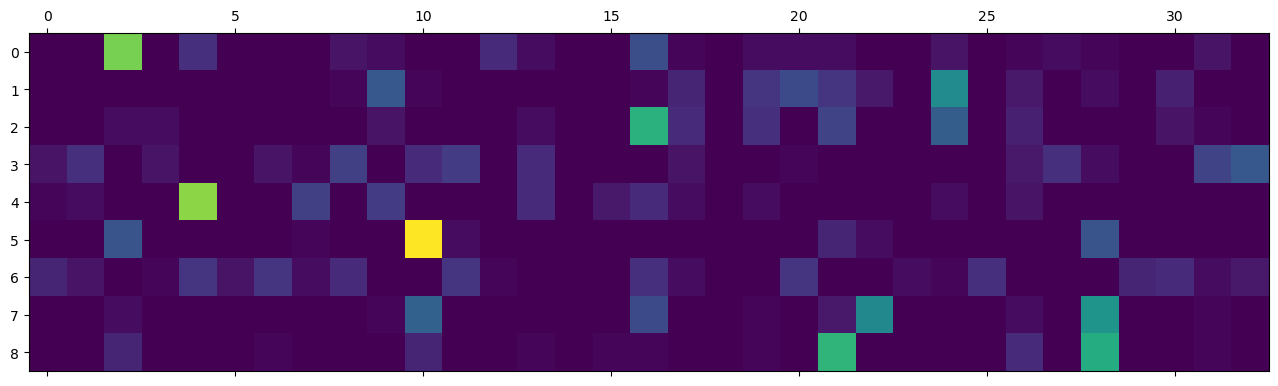

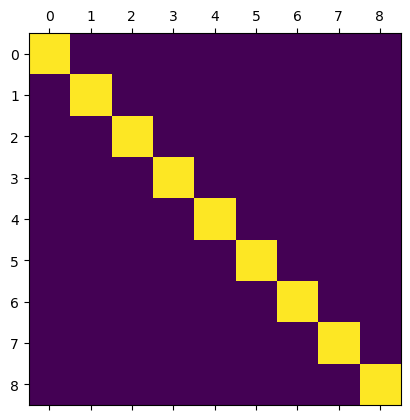

In [148]:
plt.rcParams['figure.max_open_warning'] = 100


for first in tens:
    
    for second in tens: 
        
        if first <= 660: 
            first_class = 0.0
        else: 
            first_class = 1.0
            
        if second <= 660: 
            second_class = 0.0
        else: 
            second_class = 1.0
        
        #print(f'Average LAP solution between graph {first} (class {first_class}) and graph {second} (class {second_class}).')
        average_lap('tens_LAP_solutions', first, second, 1)
        